In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras import layers
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint


from tensorflow.keras.layers import LSTM, SimpleRNN, GRU
from tensorflow.keras.layers import Dense, Dropout, concatenate

from pandas import concat
from pandas import read_csv
from helper import series_to_supervised, stage_series_to_supervised

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [3]:
dataset = pd.read_csv('../data/Merged-update_hourly.csv', index_col=0)
dataset.fillna(0, inplace=True)
data = dataset
data

,WS_S1,WS_S4,FLOW_S25A,GATE_S25A,HWS_S25A,TWS_S25A,FLOW_S25B,GATE_S25B,GATE_S25B2,HWS_S25B,TWS_S25B,PUMP_S25B,FLOW_S26,GATE_S26_1,GATE_S26_2,HWS_S26,TWS_S26,PUMP_S26,MEAN_RAIN
Time,,,,,,,,,,,,,,,,,,,
1/1/10 00:00,0.33,0.34,0.0,0.0,2.17,0.49,0.0,0.0,0.0,2.84,0.58,0.0,0.00,0.0,0.00,2.78,0.505,0.0,0.0
1/1/10 01:00,-0.29,-0.28,0.0,0.0,2.17,0.02,0.0,0.0,0.0,2.84,-0.07,0.0,0.00,0.0,0.00,2.78,-0.110,0.0,0.0
1/1/10 02:00,-0.81,-0.73,0.0,0.0,2.17,-0.49,0.0,0.0,0.0,2.84,-0.62,0.0,0.00,0.0,0.00,2.79,-0.650,0.0,0.0
1/1/10 03:00,-0.98,-0.85,0.0,0.0,2.15,-0.75,0.0,0.0,0.0,2.83,-0.82,0.0,0.00,0.0,0.00,2.79,-0.850,0.0,0.0
1/1/10 04:00,-0.69,-0.49,0.0,0.0,2.13,-0.55,0.0,0.0,0.0,2.84,-0.53,0.0,0.00,0.0,0.00,2.79,-0.550,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/20 19:00,1.24,1.19,0.0,0.0,1.92,1.25,0.0,0.0,0.0,2.86,1.31,0.0,456.34,0.0,2.61,2.49,1.290,0.0,0.0
12/31/20 20:00,1.62,1.61,0.0,0.0,1.92,1.64,0.0,0.0,0.0,2.88,1.68,0.0,380.19,0.0,2.62,2.48,1.660,0.0,0.0
12/31/20 21:00,1.98,1.90,0.0,0.0,1.93,2.00,0.0,0.0,0.0,2.89,2.04,0.0,287.12,0.0,2.62,2.54,2.040,0.0,0.0


In [4]:
print(dataset.columns)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [5]:
# specify the number of lag hours
n_hours = 24*3
K = 24
S = 24

### Target time series (4)
- 'WS_S1',  'TWS_S25A', 'TWS_S25B', 'TWS_S26',    
        
               
### Prior known covariates (9)
- 'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B',  'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN'


### Prior unknown covariates (6)
- 'FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26'

#### Target time series: water stage (4)

In [6]:
# Pre-processing
stages = dataset[['WS_S1', 'TWS_S25A', 'TWS_S25B', 'TWS_S26']]
print("stages.shape:", stages.shape)


stages_supervised = series_to_supervised(stages, n_hours, K)
print("stages_supervised.shape:", stages_supervised.shape)

stages.shape: (96432, 4)
stages_supervised.shape: (96337, 384)


In [7]:
stages_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),var1(t-70),var2(t-70),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04


#### Prior unknown covariates (6)

In [8]:
prior_unknown = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26' ]]
print("prior_unknown.shape:", prior_unknown.shape)

prior_unknown_supervised = series_to_supervised(prior_unknown, n_hours, S)
print("prior_unknown_supervised.shape:", prior_unknown_supervised.shape)

prior_unknown.shape: (96432, 6)
prior_unknown_supervised.shape: (96337, 576)


In [9]:
prior_unknown_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var1(t-71),var2(t-71),var3(t-71),var4(t-71),...,var3(t+22),var4(t+22),var5(t+22),var6(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.88,0.00,2.72,0.0,2.10,0.0,2.89,0.00,2.73
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,0.0,2.17,0.00,2.84,...,0.0,2.89,0.00,2.73,0.0,2.12,0.0,2.87,0.00,2.74
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,0.0,2.15,0.00,2.83,...,0.0,2.87,0.00,2.74,0.0,2.14,0.0,2.89,0.00,2.74
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,0.0,2.13,0.00,2.84,...,0.0,2.89,0.00,2.74,0.0,2.15,0.0,2.87,0.00,2.74
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,0.0,2.12,0.00,2.84,...,0.0,2.87,0.00,2.74,0.0,2.15,0.0,2.89,0.00,2.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,0.0,1.93,325.17,2.51,...,0.0,2.83,534.14,2.47,0.0,1.92,0.0,2.86,456.34,2.49
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,0.0,1.94,406.56,2.48,...,0.0,2.86,456.34,2.49,0.0,1.92,0.0,2.88,380.19,2.48
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.0,1.94,445.67,2.43,...,0.0,2.88,380.19,2.48,0.0,1.93,0.0,2.89,287.12,2.54


#### Prior known covariates (9)

In [10]:
prior_known = dataset[['WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', 'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]
print("prior_known.shape:", prior_known.shape)

prior_known_supervised = series_to_supervised(prior_known, n_hours, S)
print("prior_known_supervised.shape:", prior_known_supervised.shape)

prior_known.shape: (96432, 9)
prior_known_supervised.shape: (96337, 864)


In [11]:
prior_known_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var1(t-71),...,var9(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23),var5(t+23),var6(t+23),var7(t+23),var8(t+23),var9(t+23)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.34,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.28,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,-0.28,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.73,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,-0.73,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.85,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,-0.85,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,-0.49,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,-0.49,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.000000,0.21,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.79,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,1.31,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
12/30/20 21:00,1.31,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.000000,0.86,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
12/30/20 22:00,0.86,0.0,0.0,2.58,0.0,0.0,2.57,0.0,0.000000,0.42,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


### N_out, N_in, K

#### all past covariates in past $w$ hours

In [12]:
# 15 covariates in total
cov = dataset[['FLOW_S25A', 'HWS_S25A', 'FLOW_S25B', 'HWS_S25B', 'FLOW_S26', 'HWS_S26',\
                   'WS_S4', 'GATE_S25A', 'GATE_S25B', 'GATE_S25B2', 'PUMP_S25B', \
                    'GATE_S26_1', 'GATE_S26_2', 'PUMP_S26', 'MEAN_RAIN']]

cov_supervised = series_to_supervised(cov, n_hours, S)
print("cov_supervised.shape:", cov_supervised.shape)

cov_supervised.shape: (96337, 1440)


In [13]:
past_cov_supervised = cov_supervised.iloc[:, :n_hours*cov.shape[1]]

In [14]:
past_cov_supervised  # 6 + 9 = 15 features

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.76,2.13,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 01:00,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.78,2.03,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 02:00,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.77,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 03:00,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.77,0.83,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
1/4/10 04:00,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.77,0.31,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.57,1.57,0.0,0.0,2.56,0.0,0.0,2.57,0.0,0.0
12/30/20 21:00,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.55,1.94,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0
12/30/20 22:00,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.56,2.08,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0


#### all target water stages in past $w$ hours

In [15]:
past_ws_supervised = stages_supervised.iloc[:, :n_hours*stages.shape[1]]
past_ws_supervised.columns = ['past_ws_supervised_' + i for i in list(past_ws_supervised.columns)]

In [16]:
past_ws_supervised  # 4

,past_ws_supervised_var1(t-72),past_ws_supervised_var2(t-72),past_ws_supervised_var3(t-72),past_ws_supervised_var4(t-72),past_ws_supervised_var1(t-71),past_ws_supervised_var2(t-71),past_ws_supervised_var3(t-71),past_ws_supervised_var4(t-71),past_ws_supervised_var1(t-70),past_ws_supervised_var2(t-70),...,past_ws_supervised_var3(t-3),past_ws_supervised_var4(t-3),past_ws_supervised_var1(t-2),past_ws_supervised_var2(t-2),past_ws_supervised_var3(t-2),past_ws_supervised_var4(t-2),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
Time,,,,,,,,,,,,,,,,,,,,,
1/4/10 00:00,0.33,0.49,0.58,0.505,-0.29,0.02,-0.07,-0.11,-0.81,-0.49,...,1.38,1.34,1.79,1.92,1.94,1.91,2.11,2.29,2.27,2.21
1/4/10 01:00,-0.29,0.02,-0.07,-0.110,-0.81,-0.49,-0.62,-0.65,-0.98,-0.75,...,1.94,1.91,2.11,2.29,2.27,2.21,2.07,2.27,2.26,2.22
1/4/10 02:00,-0.81,-0.49,-0.62,-0.650,-0.98,-0.75,-0.82,-0.85,-0.69,-0.55,...,2.27,2.21,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72
1/4/10 03:00,-0.98,-0.75,-0.82,-0.850,-0.69,-0.55,-0.53,-0.55,0.03,0.12,...,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96
1/4/10 04:00,-0.69,-0.55,-0.53,-0.550,0.03,0.12,0.19,0.15,0.86,0.97,...,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/30/20 20:00,1.93,1.97,2.03,1.990,1.48,1.48,1.59,1.54,0.98,0.97,...,0.60,0.54,1.14,1.18,1.17,1.25,1.62,1.65,1.70,1.67
12/30/20 21:00,1.48,1.48,1.59,1.540,0.98,0.97,1.05,1.01,0.58,0.61,...,1.17,1.25,1.62,1.65,1.70,1.67,1.93,1.95,2.00,2.00
12/30/20 22:00,0.98,0.97,1.05,1.010,0.58,0.61,0.72,0.66,0.04,0.03,...,1.70,1.67,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25


#### merge all data (ws, covariates) in past $w$ hours

In [17]:
columns = []
for i in range(n_hours):
    columns = columns + past_cov_supervised.columns[i*cov.shape[1]:(i+1)*cov.shape[1]].tolist()
    columns = columns + past_ws_supervised.columns[i*stages.shape[1]:(i+1)*stages.shape[1]].tolist()
# columns

In [18]:
past_cov_supervised.reset_index(drop=True, inplace=True)
past_ws_supervised.reset_index(drop=True, inplace=True)

past_cov_ws_supervised = pd.concat([past_cov_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :], 
                                    past_ws_supervised.iloc[:min(past_cov_supervised.shape[0], past_ws_supervised.shape[0]), :]], 
                                   axis=1)

past_cov_ws_supervised = past_cov_ws_supervised[columns]

In [19]:
past_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),past_ws_supervised_var1(t-1),past_ws_supervised_var2(t-1),past_ws_supervised_var3(t-1),past_ws_supervised_var4(t-1)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.11,2.29,2.27,2.21
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,2.07,2.27,2.26,2.22
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,1.57,1.80,1.80,1.72
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.81,1.04,1.03,0.96
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.00,0.0,0.0,0.00,0.0,0.0,0.27,0.53,0.50,0.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,2.56,0.0,0.0,2.57,0.0,0.0,1.62,1.65,1.70,1.67
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,1.93,1.95,2.00,2.00
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.57,0.0,0.0,2.57,0.0,0.0,2.19,2.21,2.25,2.25
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.57,0.0,0.0,2.57,0.0,0.0,2.11,2.12,2.22,2.19


#### shift prior known covariates in future  $S$ steps to the past

In [20]:
shift_prior_known_supervised = prior_known_supervised.iloc[:, S*prior_known.shape[1]:]
shift_prior_known_supervised.reset_index(drop=True, inplace=True)
shift_prior_known_supervised.columns = ['shift_prior_known_supervised_' + i for i in list(shift_prior_known_supervised.columns)]
shift_prior_known_supervised

,shift_prior_known_supervised_var1(t-48),shift_prior_known_supervised_var2(t-48),shift_prior_known_supervised_var3(t-48),shift_prior_known_supervised_var4(t-48),shift_prior_known_supervised_var5(t-48),shift_prior_known_supervised_var6(t-48),shift_prior_known_supervised_var7(t-48),shift_prior_known_supervised_var8(t-48),shift_prior_known_supervised_var9(t-48),shift_prior_known_supervised_var1(t-47),...,shift_prior_known_supervised_var9(t+22),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.60,0.0,0.0,0.00,0.0,0.0,2.61,0.0,0.0,-0.07,...,0.0,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,-0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.68,...,0.0,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,-0.68,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-1.02,...,0.0,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,-1.02,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.97,...,0.0,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,-0.97,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,-0.50,...,0.0,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.91,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.67,...,0.0,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,1.67,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,1.16,...,0.0,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,1.16,0.0,0.0,2.57,0.0,0.0,2.57,0.0,0.0,0.68,...,0.0,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.68,0.0,0.0,2.57,0.0,0.0,2.56,0.0,0.0,0.24,...,0.0,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### merge all past data and shifted prior know future covariate

In [21]:
columns1 = []
for i in range(n_hours):
    columns1 = columns1 + past_cov_ws_supervised.columns[i*data.shape[1]:(i+1)*data.shape[1]].tolist()
    columns1 = columns1 + shift_prior_known_supervised.columns[i*prior_known.shape[1]:(i+1)*prior_known.shape[1]].tolist()
# columns

In [22]:
shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :], 
                                                 shift_prior_known_supervised.iloc[:min(past_cov_ws_supervised.shape[0], shift_prior_known_supervised.shape[0]), :]],
                                                axis=1)

shift_prior_known_cov_ws_supervised = shift_prior_known_cov_ws_supervised[columns1]

In [23]:
# shift_prior_known_cov_ws_supervised = pd.concat([past_cov_ws_supervised, shift_prior_known_supervised], 
#                                                      axis=1)

In [24]:
shift_prior_known_cov_ws_supervised

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,past_ws_supervised_var4(t-1),shift_prior_known_supervised_var1(t+23),shift_prior_known_supervised_var2(t+23),shift_prior_known_supervised_var3(t+23),shift_prior_known_supervised_var4(t+23),shift_prior_known_supervised_var5(t+23),shift_prior_known_supervised_var6(t+23),shift_prior_known_supervised_var7(t+23),shift_prior_known_supervised_var8(t+23),shift_prior_known_supervised_var9(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,2.21,1.99,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,2.22,2.17,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,1.72,2.06,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,0.96,1.50,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,0.42,0.86,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,1.67,1.19,0.0,0.0,0.0,0.0,0.0,2.61,0.0,0.0
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,2.00,1.61,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,2.25,1.90,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,2.19,2.03,0.0,0.0,0.0,0.0,0.0,2.62,0.0,0.0


#### target water stage in future $k$ time steps

In [25]:
future_ws_supervised = stages_supervised.iloc[:, n_hours*stages.shape[1]:]
future_ws_supervised.reset_index(drop=True, inplace=True)
future_ws_supervised

,var1(t),var2(t),var3(t),var4(t),var1(t+1),var2(t+1),var3(t+1),var4(t+1),var1(t+2),var2(t+2),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,2.07,2.27,2.26,2.22,1.57,1.80,1.80,1.72,0.81,1.04,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,1.57,1.80,1.80,1.72,0.81,1.04,1.03,0.96,0.27,0.53,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.81,1.04,1.03,0.96,0.27,0.53,0.50,0.42,-0.29,-0.02,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.27,0.53,0.50,0.42,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,-0.29,-0.02,-0.06,-0.14,-0.68,-0.41,-0.49,-0.57,-0.64,-0.46,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,1.93,1.95,2.00,2.00,2.19,2.21,2.25,2.25,2.11,2.12,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,2.19,2.21,2.25,2.25,2.11,2.12,2.22,2.19,1.65,1.69,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,2.11,2.12,2.22,2.19,1.65,1.69,1.76,1.72,1.24,1.24,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,1.65,1.69,1.76,1.72,1.24,1.24,1.37,1.32,0.76,0.73,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Concatenation

In [26]:
all_data = concat([shift_prior_known_cov_ws_supervised, 
                   future_ws_supervised.iloc[:shift_prior_known_cov_ws_supervised.shape[0], :]], 
                  axis=1)
# print("all_data", all_data)
print("all_data.shape:", all_data.shape)

all_data.shape: (96337, 2112)


In [27]:
all_data

,var1(t-72),var2(t-72),var3(t-72),var4(t-72),var5(t-72),var6(t-72),var7(t-72),var8(t-72),var9(t-72),var10(t-72),...,var3(t+21),var4(t+21),var1(t+22),var2(t+22),var3(t+22),var4(t+22),var1(t+23),var2(t+23),var3(t+23),var4(t+23)
0,0.0,2.17,0.00,2.84,0.00,2.78,0.34,0.0,0.0,0.00,...,1.07,1.04,1.45,1.61,1.63,1.58,1.91,2.05,2.08,2.02
1,0.0,2.17,0.00,2.84,0.00,2.78,-0.28,0.0,0.0,0.00,...,1.63,1.58,1.91,2.05,2.08,2.02,2.14,2.32,2.33,2.26
2,0.0,2.17,0.00,2.84,0.00,2.79,-0.73,0.0,0.0,0.00,...,2.08,2.02,2.14,2.32,2.33,2.26,2.07,2.28,2.29,2.23
3,0.0,2.15,0.00,2.83,0.00,2.79,-0.85,0.0,0.0,0.00,...,2.33,2.26,2.07,2.28,2.29,2.23,1.55,1.78,1.78,1.72
4,0.0,2.13,0.00,2.84,0.00,2.79,-0.49,0.0,0.0,0.00,...,2.29,2.23,1.55,1.78,1.78,1.72,0.85,1.08,1.05,0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96332,0.0,1.92,240.09,2.52,302.67,2.55,1.79,0.0,0.0,2.57,...,0.23,0.21,0.77,0.74,0.75,0.75,1.24,1.25,1.31,1.29
96333,0.0,1.93,325.17,2.51,393.59,2.48,1.31,0.0,0.0,2.57,...,0.75,0.75,1.24,1.25,1.31,1.29,1.62,1.64,1.68,1.66
96334,0.0,1.94,406.56,2.48,475.32,2.40,0.86,0.0,0.0,2.58,...,1.31,1.29,1.62,1.64,1.68,1.66,1.98,2.00,2.04,2.04
96335,0.0,1.94,445.67,2.43,519.46,2.30,0.42,0.0,0.0,2.57,...,1.68,1.66,1.98,2.00,2.04,2.04,2.13,2.13,2.21,2.18


### Train & Test set

In [28]:
all_data = all_data.values
n_train_hours = int(len(all_data)*0.8)
print("n_train_hours:", n_train_hours)


train = all_data[:n_train_hours, :]
test = all_data[n_train_hours:, :]

n_train_hours: 77069


In [29]:
n_obs = n_hours * (prior_known.shape[1]+data.shape[1])
n_obs

2016

### Normalization

In [30]:
# split into input and outputs
all_features = prior_known.shape[1] + data.shape[1]
n_obs = n_hours * all_features
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape", train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
train_X = scaler.fit_transform(train_X)
train_y = scaler.fit_transform(train_y)
test_X = scaler.fit_transform(test_X)
test_y = scaler.fit_transform(test_y)

train_X.shape, train_y.shape, test_X.shape, test_y.shape (77069, 2016) (77069, 96) (19268, 2016) (19268, 96)


In [31]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, all_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, all_features))
print("train_X.shape, train_y.shape, test_X.shape, test_y.shape: \n", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

train_X.shape, train_y.shape, test_X.shape, test_y.shape: 
 (77069, 72, 28) (77069, 96) (19268, 72, 28) (19268, 96)


### Model

In [33]:
model_input = Input(shape=(train_X.shape[1], train_X.shape[2]))

# 3 cnn with skip connection
x1 = layers.Conv1D(filters=256, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)

x1_merge1 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=128, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge1)

x1_merge2 = concatenate([model_input, x1])

x1 = layers.Conv1D(filters=64, 
                    kernel_size=2, 
                    activation='relu', 
                    padding='same', 
                    kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x1_merge2)


# 3 rnn with skip connection
x2 = layers.SimpleRNN(128, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(model_input)
x2_merge1 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(64, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge1)

x2_merge2 = concatenate([model_input, x2])

x2 = layers.SimpleRNN(32, 
                     activation='relu', 
                     return_sequences=True,
                     recurrent_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5),
                     kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x2_merge2)

merge = concatenate([model_input, x1, x2])
merge = layers.Flatten()(merge)
# x = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(merge)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(128, activation='relu', kernel_regularizer=keras.regularizers.L1L2(l1=1e-5, l2=1e-5))(x)
# x = Dense(64, activation='relu')(x)
x = Dense(train_y.shape[1])(merge)


ws_pararcnn = Model(model_input, x)
ws_pararcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 28)]     0                                            
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 72, 256)      14592       input_2[0][0]                    
__________________________________________________________________________________________________
simple_rnn_3 (SimpleRNN)        (None, 72, 128)      20096       input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_5 (Concatenate)     (None, 72, 284)      0           input_2[0][0]                    
                                                                 conv1d_3[0][0]             

Epoch 1/8000


2023-01-05 23:41:43.286017: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-01-05 23:41:43.497789: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2023-01-05 23:41:44.665956: E tensorflow/stream_executor/gpu/asm_compiler.cc:110] You are using ptxas 8.x, but TF requires ptxas 9.x (and strongly prefers >= 9.2.88).  Compilation of XLA kernels below will likely fail.

You do not need to update CUDA; cherry-picking the ptxas binary is sufficient.
2023-01-05 23:41:45.038755: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 65280, output: ptxas fatal   : Value 'sm_61' is not defined for option 'gpu-name'

Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.



Epoch 00001: val_mae improved from inf to 0.04673, saving model to saved_model/ws_pararcnn_sc1_3layer_24h.h5
151/151 - 50s - loss: 0.0743 - mae: 0.0548 - val_loss: 0.0501 - val_mae: 0.0467
Epoch 2/8000

Epoch 00002: val_mae improved from 0.04673 to 0.03805, saving model to saved_model/ws_pararcnn_sc1_3layer_24h.h5
151/151 - 20s - loss: 0.0374 - mae: 0.0257 - val_loss: 0.0305 - val_mae: 0.0380
Epoch 3/8000

Epoch 00003: val_mae improved from 0.03805 to 0.03498, saving model to saved_model/ws_pararcnn_sc1_3layer_24h.h5
151/151 - 19s - loss: 0.0241 - mae: 0.0199 - val_loss: 0.0213 - val_mae: 0.0350
Epoch 4/8000

Epoch 00004: val_mae improved from 0.03498 to 0.03113, saving model to saved_model/ws_pararcnn_sc1_3layer_24h.h5
151/151 - 19s - loss: 0.0171 - mae: 0.0170 - val_loss: 0.0156 - val_mae: 0.0311
Epoch 5/8000

Epoch 00005: val_mae improved from 0.03113 to 0.03020, saving model to saved_model/ws_pararcnn_sc1_3layer_24h.h5
151/151 - 19s - loss: 0.0127 - mae: 0.0151 - val_loss: 0.0120 

Epoch 47/8000

Epoch 00047: val_mae improved from 0.01535 to 0.01534, saving model to saved_model/ws_pararcnn_sc1_3layer_24h.h5
151/151 - 20s - loss: 2.7142e-04 - mae: 0.0084 - val_loss: 5.2019e-04 - val_mae: 0.0153
Epoch 48/8000

Epoch 00048: val_mae did not improve from 0.01534
151/151 - 19s - loss: 2.7025e-04 - mae: 0.0083 - val_loss: 5.4590e-04 - val_mae: 0.0159
Epoch 49/8000

Epoch 00049: val_mae did not improve from 0.01534
151/151 - 19s - loss: 2.7502e-04 - mae: 0.0085 - val_loss: 5.4752e-04 - val_mae: 0.0159
Epoch 50/8000

Epoch 00050: val_mae did not improve from 0.01534
151/151 - 19s - loss: 2.6941e-04 - mae: 0.0083 - val_loss: 5.8381e-04 - val_mae: 0.0164
Epoch 51/8000

Epoch 00051: val_mae improved from 0.01534 to 0.01513, saving model to saved_model/ws_pararcnn_sc1_3layer_24h.h5
151/151 - 20s - loss: 2.7009e-04 - mae: 0.0084 - val_loss: 5.1313e-04 - val_mae: 0.0151
Epoch 52/8000

Epoch 00052: val_mae did not improve from 0.01513
151/151 - 19s - loss: 2.6799e-04 - mae: 0.00

Epoch 97/8000

Epoch 00097: val_mae did not improve from 0.01355
151/151 - 19s - loss: 2.4429e-04 - mae: 0.0078 - val_loss: 4.8807e-04 - val_mae: 0.0148
Epoch 98/8000

Epoch 00098: val_mae did not improve from 0.01355
151/151 - 20s - loss: 2.4292e-04 - mae: 0.0078 - val_loss: 4.9961e-04 - val_mae: 0.0151
Epoch 99/8000

Epoch 00099: val_mae did not improve from 0.01355
151/151 - 19s - loss: 2.4111e-04 - mae: 0.0077 - val_loss: 5.5352e-04 - val_mae: 0.0161
Epoch 100/8000

Epoch 00100: val_mae did not improve from 0.01355
151/151 - 19s - loss: 2.4258e-04 - mae: 0.0078 - val_loss: 5.5809e-04 - val_mae: 0.0158
Epoch 101/8000

Epoch 00101: val_mae did not improve from 0.01355
151/151 - 19s - loss: 2.4159e-04 - mae: 0.0078 - val_loss: 5.3725e-04 - val_mae: 0.0156
Epoch 102/8000

Epoch 00102: val_mae did not improve from 0.01355
151/151 - 20s - loss: 2.4397e-04 - mae: 0.0079 - val_loss: 6.0265e-04 - val_mae: 0.0165
Epoch 103/8000

Epoch 00103: val_mae did not improve from 0.01355
151/151 - 20s

Epoch 151/8000

Epoch 00151: val_mae did not improve from 0.01355
151/151 - 20s - loss: 2.3005e-04 - mae: 0.0075 - val_loss: 4.5615e-04 - val_mae: 0.0143
Epoch 152/8000

Epoch 00152: val_mae did not improve from 0.01355
151/151 - 20s - loss: 2.3106e-04 - mae: 0.0076 - val_loss: 4.5467e-04 - val_mae: 0.0143
Epoch 153/8000

Epoch 00153: val_mae did not improve from 0.01355
151/151 - 19s - loss: 2.3189e-04 - mae: 0.0076 - val_loss: 5.2962e-04 - val_mae: 0.0159
Epoch 154/8000

Epoch 00154: val_mae did not improve from 0.01355
151/151 - 19s - loss: 2.2835e-04 - mae: 0.0075 - val_loss: 4.3770e-04 - val_mae: 0.0137
Epoch 155/8000

Epoch 00155: val_mae did not improve from 0.01355
151/151 - 19s - loss: 2.3037e-04 - mae: 0.0076 - val_loss: 4.8677e-04 - val_mae: 0.0149
Epoch 156/8000

Epoch 00156: val_mae did not improve from 0.01355
151/151 - 20s - loss: 2.2760e-04 - mae: 0.0075 - val_loss: 4.3683e-04 - val_mae: 0.0140
Epoch 157/8000

Epoch 00157: val_mae did not improve from 0.01355
151/151 - 

Epoch 203/8000

Epoch 00203: val_mae did not improve from 0.01244
151/151 - 19s - loss: 2.2237e-04 - mae: 0.0074 - val_loss: 4.8047e-04 - val_mae: 0.0144
Epoch 204/8000

Epoch 00204: val_mae did not improve from 0.01244
151/151 - 20s - loss: 2.2610e-04 - mae: 0.0075 - val_loss: 4.9970e-04 - val_mae: 0.0151
Epoch 205/8000

Epoch 00205: val_mae did not improve from 0.01244
151/151 - 19s - loss: 2.2375e-04 - mae: 0.0074 - val_loss: 4.8554e-04 - val_mae: 0.0148
Epoch 206/8000

Epoch 00206: val_mae did not improve from 0.01244
151/151 - 20s - loss: 2.2588e-04 - mae: 0.0075 - val_loss: 4.8845e-04 - val_mae: 0.0148
Epoch 207/8000

Epoch 00207: val_mae did not improve from 0.01244
151/151 - 19s - loss: 2.1981e-04 - mae: 0.0073 - val_loss: 4.5497e-04 - val_mae: 0.0141
Epoch 208/8000

Epoch 00208: val_mae did not improve from 0.01244
151/151 - 19s - loss: 2.2236e-04 - mae: 0.0074 - val_loss: 4.5307e-04 - val_mae: 0.0141
Epoch 209/8000

Epoch 00209: val_mae did not improve from 0.01244
151/151 - 

Epoch 257/8000

Epoch 00257: val_mae did not improve from 0.01244
151/151 - 20s - loss: 2.1636e-04 - mae: 0.0072 - val_loss: 4.0166e-04 - val_mae: 0.0133
Epoch 258/8000

Epoch 00258: val_mae did not improve from 0.01244
151/151 - 19s - loss: 2.1854e-04 - mae: 0.0073 - val_loss: 4.5768e-04 - val_mae: 0.0141
Epoch 259/8000

Epoch 00259: val_mae did not improve from 0.01244
151/151 - 19s - loss: 2.1743e-04 - mae: 0.0073 - val_loss: 4.5322e-04 - val_mae: 0.0141
Epoch 260/8000

Epoch 00260: val_mae improved from 0.01244 to 0.01201, saving model to saved_model/ws_pararcnn_sc1_3layer_24h.h5
151/151 - 20s - loss: 2.1851e-04 - mae: 0.0073 - val_loss: 3.4169e-04 - val_mae: 0.0120
Epoch 261/8000

Epoch 00261: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.1821e-04 - mae: 0.0073 - val_loss: 4.6015e-04 - val_mae: 0.0142
Epoch 262/8000

Epoch 00262: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.2108e-04 - mae: 0.0074 - val_loss: 4.5360e-04 - val_mae: 0.0144
Epoch 263/800

Epoch 310/8000

Epoch 00310: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.1250e-04 - mae: 0.0071 - val_loss: 4.3373e-04 - val_mae: 0.0138
Epoch 311/8000

Epoch 00311: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.1323e-04 - mae: 0.0072 - val_loss: 3.8108e-04 - val_mae: 0.0125
Epoch 312/8000

Epoch 00312: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.1222e-04 - mae: 0.0071 - val_loss: 4.1374e-04 - val_mae: 0.0136
Epoch 313/8000

Epoch 00313: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.1466e-04 - mae: 0.0072 - val_loss: 4.2534e-04 - val_mae: 0.0138
Epoch 314/8000

Epoch 00314: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.1461e-04 - mae: 0.0073 - val_loss: 4.0206e-04 - val_mae: 0.0130
Epoch 315/8000

Epoch 00315: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.1432e-04 - mae: 0.0072 - val_loss: 3.8518e-04 - val_mae: 0.0125
Epoch 316/8000

Epoch 00316: val_mae did not improve from 0.01201
151/151 - 

Epoch 364/8000

Epoch 00364: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.0791e-04 - mae: 0.0070 - val_loss: 4.2418e-04 - val_mae: 0.0136
Epoch 365/8000

Epoch 00365: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.1025e-04 - mae: 0.0071 - val_loss: 4.1877e-04 - val_mae: 0.0135
Epoch 366/8000

Epoch 00366: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.0899e-04 - mae: 0.0071 - val_loss: 3.9764e-04 - val_mae: 0.0131
Epoch 367/8000

Epoch 00367: val_mae did not improve from 0.01201
151/151 - 20s - loss: 2.1196e-04 - mae: 0.0072 - val_loss: 5.2174e-04 - val_mae: 0.0151
Epoch 368/8000

Epoch 00368: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.0958e-04 - mae: 0.0071 - val_loss: 4.0373e-04 - val_mae: 0.0132
Epoch 369/8000

Epoch 00369: val_mae did not improve from 0.01201
151/151 - 19s - loss: 2.0540e-04 - mae: 0.0069 - val_loss: 4.1059e-04 - val_mae: 0.0132
Epoch 370/8000

Epoch 00370: val_mae did not improve from 0.01201
151/151 - 

Epoch 417/8000

Epoch 00417: val_mae did not improve from 0.01192
151/151 - 19s - loss: 2.1000e-04 - mae: 0.0072 - val_loss: 3.5470e-04 - val_mae: 0.0120
Epoch 418/8000

Epoch 00418: val_mae did not improve from 0.01192
151/151 - 19s - loss: 2.0644e-04 - mae: 0.0070 - val_loss: 3.7688e-04 - val_mae: 0.0125
Epoch 419/8000

Epoch 00419: val_mae did not improve from 0.01192
151/151 - 19s - loss: 2.0543e-04 - mae: 0.0070 - val_loss: 4.6930e-04 - val_mae: 0.0144
Epoch 420/8000

Epoch 00420: val_mae did not improve from 0.01192
151/151 - 20s - loss: 2.0712e-04 - mae: 0.0071 - val_loss: 3.7977e-04 - val_mae: 0.0127
Epoch 421/8000

Epoch 00421: val_mae did not improve from 0.01192
151/151 - 25s - loss: 2.0570e-04 - mae: 0.0070 - val_loss: 3.9442e-04 - val_mae: 0.0130
Epoch 422/8000

Epoch 00422: val_mae did not improve from 0.01192
151/151 - 29s - loss: 2.0603e-04 - mae: 0.0070 - val_loss: 3.6970e-04 - val_mae: 0.0122
Epoch 423/8000

Epoch 00423: val_mae did not improve from 0.01192
151/151 - 

Epoch 469/8000

Epoch 00469: val_mae did not improve from 0.01166
151/151 - 26s - loss: 2.0515e-04 - mae: 0.0070 - val_loss: 4.3970e-04 - val_mae: 0.0139
Epoch 470/8000

Epoch 00470: val_mae did not improve from 0.01166
151/151 - 25s - loss: 2.0437e-04 - mae: 0.0070 - val_loss: 3.7879e-04 - val_mae: 0.0126
Epoch 471/8000

Epoch 00471: val_mae did not improve from 0.01166
151/151 - 26s - loss: 2.0509e-04 - mae: 0.0070 - val_loss: 3.9185e-04 - val_mae: 0.0131
Epoch 472/8000

Epoch 00472: val_mae did not improve from 0.01166
151/151 - 26s - loss: 2.0330e-04 - mae: 0.0070 - val_loss: 4.1684e-04 - val_mae: 0.0135
Epoch 473/8000

Epoch 00473: val_mae did not improve from 0.01166
151/151 - 26s - loss: 2.0441e-04 - mae: 0.0070 - val_loss: 4.1928e-04 - val_mae: 0.0134
Epoch 474/8000

Epoch 00474: val_mae did not improve from 0.01166
151/151 - 26s - loss: 2.0313e-04 - mae: 0.0069 - val_loss: 4.8561e-04 - val_mae: 0.0152
Epoch 475/8000

Epoch 00475: val_mae did not improve from 0.01166
151/151 - 

Epoch 523/8000

Epoch 00523: val_mae did not improve from 0.01166
151/151 - 23s - loss: 2.0004e-04 - mae: 0.0069 - val_loss: 3.9886e-04 - val_mae: 0.0131
Epoch 524/8000

Epoch 00524: val_mae did not improve from 0.01166
151/151 - 24s - loss: 2.0200e-04 - mae: 0.0070 - val_loss: 4.4166e-04 - val_mae: 0.0139
Epoch 525/8000

Epoch 00525: val_mae did not improve from 0.01166
151/151 - 25s - loss: 2.0097e-04 - mae: 0.0069 - val_loss: 4.4732e-04 - val_mae: 0.0139
Epoch 526/8000

Epoch 00526: val_mae did not improve from 0.01166
151/151 - 25s - loss: 2.0133e-04 - mae: 0.0069 - val_loss: 4.0488e-04 - val_mae: 0.0128
Epoch 527/8000

Epoch 00527: val_mae did not improve from 0.01166
151/151 - 25s - loss: 2.0242e-04 - mae: 0.0070 - val_loss: 3.7410e-04 - val_mae: 0.0125
Epoch 528/8000

Epoch 00528: val_mae did not improve from 0.01166
151/151 - 25s - loss: 2.0013e-04 - mae: 0.0069 - val_loss: 4.2858e-04 - val_mae: 0.0134
Epoch 529/8000

Epoch 00529: val_mae did not improve from 0.01166
151/151 - 

Epoch 577/8000

Epoch 00577: val_mae did not improve from 0.01166
151/151 - 23s - loss: 1.9809e-04 - mae: 0.0068 - val_loss: 3.7937e-04 - val_mae: 0.0126
Epoch 578/8000

Epoch 00578: val_mae did not improve from 0.01166
151/151 - 23s - loss: 1.9856e-04 - mae: 0.0069 - val_loss: 4.4331e-04 - val_mae: 0.0139
Epoch 579/8000

Epoch 00579: val_mae did not improve from 0.01166
151/151 - 23s - loss: 1.9832e-04 - mae: 0.0069 - val_loss: 4.0952e-04 - val_mae: 0.0133
Epoch 580/8000

Epoch 00580: val_mae did not improve from 0.01166
151/151 - 23s - loss: 1.9856e-04 - mae: 0.0068 - val_loss: 4.3305e-04 - val_mae: 0.0135
Epoch 581/8000

Epoch 00581: val_mae did not improve from 0.01166
151/151 - 23s - loss: 1.9977e-04 - mae: 0.0069 - val_loss: 3.6440e-04 - val_mae: 0.0125
Epoch 582/8000

Epoch 00582: val_mae did not improve from 0.01166
151/151 - 23s - loss: 1.9652e-04 - mae: 0.0068 - val_loss: 3.3574e-04 - val_mae: 0.0119
Epoch 583/8000

Epoch 00583: val_mae did not improve from 0.01166
151/151 - 

Epoch 630/8000

Epoch 00630: val_mae did not improve from 0.01144
151/151 - 24s - loss: 1.9922e-04 - mae: 0.0069 - val_loss: 4.2695e-04 - val_mae: 0.0137
Epoch 631/8000

Epoch 00631: val_mae did not improve from 0.01144
151/151 - 23s - loss: 1.9586e-04 - mae: 0.0068 - val_loss: 4.1541e-04 - val_mae: 0.0134
Epoch 632/8000

Epoch 00632: val_mae did not improve from 0.01144
151/151 - 23s - loss: 1.9789e-04 - mae: 0.0069 - val_loss: 4.0439e-04 - val_mae: 0.0131
Epoch 633/8000

Epoch 00633: val_mae did not improve from 0.01144
151/151 - 23s - loss: 1.9426e-04 - mae: 0.0067 - val_loss: 3.9332e-04 - val_mae: 0.0128
Epoch 634/8000

Epoch 00634: val_mae did not improve from 0.01144
151/151 - 22s - loss: 1.9605e-04 - mae: 0.0068 - val_loss: 5.5285e-04 - val_mae: 0.0162
Epoch 635/8000

Epoch 00635: val_mae did not improve from 0.01144
151/151 - 23s - loss: 1.9782e-04 - mae: 0.0068 - val_loss: 3.9186e-04 - val_mae: 0.0129
Epoch 636/8000

Epoch 00636: val_mae did not improve from 0.01144
151/151 - 

Epoch 684/8000

Epoch 00684: val_mae did not improve from 0.01144
151/151 - 23s - loss: 1.9610e-04 - mae: 0.0068 - val_loss: 3.9262e-04 - val_mae: 0.0130
Epoch 685/8000

Epoch 00685: val_mae did not improve from 0.01144
151/151 - 23s - loss: 1.9431e-04 - mae: 0.0067 - val_loss: 3.5132e-04 - val_mae: 0.0122
Epoch 686/8000

Epoch 00686: val_mae did not improve from 0.01144
151/151 - 23s - loss: 1.9771e-04 - mae: 0.0069 - val_loss: 3.4653e-04 - val_mae: 0.0118
Epoch 687/8000

Epoch 00687: val_mae did not improve from 0.01144
151/151 - 23s - loss: 1.9421e-04 - mae: 0.0067 - val_loss: 3.5542e-04 - val_mae: 0.0121
Epoch 688/8000

Epoch 00688: val_mae did not improve from 0.01144
151/151 - 26s - loss: 1.9366e-04 - mae: 0.0067 - val_loss: 3.8587e-04 - val_mae: 0.0129
Epoch 689/8000

Epoch 00689: val_mae did not improve from 0.01144
151/151 - 25s - loss: 1.9460e-04 - mae: 0.0067 - val_loss: 3.8381e-04 - val_mae: 0.0129
Epoch 690/8000

Epoch 00690: val_mae did not improve from 0.01144
151/151 - 

Epoch 738/8000

Epoch 00738: val_mae did not improve from 0.01144
151/151 - 23s - loss: 1.9310e-04 - mae: 0.0067 - val_loss: 3.8070e-04 - val_mae: 0.0127
Epoch 739/8000

Epoch 00739: val_mae did not improve from 0.01144
151/151 - 24s - loss: 1.9233e-04 - mae: 0.0067 - val_loss: 4.1269e-04 - val_mae: 0.0133
Epoch 740/8000

Epoch 00740: val_mae did not improve from 0.01144
151/151 - 25s - loss: 1.9174e-04 - mae: 0.0066 - val_loss: 3.3467e-04 - val_mae: 0.0119
Epoch 741/8000

Epoch 00741: val_mae did not improve from 0.01144
151/151 - 25s - loss: 1.9622e-04 - mae: 0.0068 - val_loss: 4.0741e-04 - val_mae: 0.0132
Epoch 742/8000

Epoch 00742: val_mae did not improve from 0.01144
151/151 - 25s - loss: 1.9229e-04 - mae: 0.0067 - val_loss: 3.3911e-04 - val_mae: 0.0118
Epoch 743/8000

Epoch 00743: val_mae did not improve from 0.01144
151/151 - 26s - loss: 1.9324e-04 - mae: 0.0067 - val_loss: 4.1710e-04 - val_mae: 0.0135
Epoch 744/8000

Epoch 00744: val_mae did not improve from 0.01144
151/151 - 

Epoch 791/8000

Epoch 00791: val_mae did not improve from 0.01131
151/151 - 22s - loss: 1.9094e-04 - mae: 0.0066 - val_loss: 4.3601e-04 - val_mae: 0.0139
Epoch 792/8000

Epoch 00792: val_mae did not improve from 0.01131
151/151 - 22s - loss: 1.9416e-04 - mae: 0.0068 - val_loss: 3.3393e-04 - val_mae: 0.0116
Epoch 793/8000

Epoch 00793: val_mae did not improve from 0.01131
151/151 - 23s - loss: 1.9157e-04 - mae: 0.0067 - val_loss: 3.9609e-04 - val_mae: 0.0129
Epoch 794/8000

Epoch 00794: val_mae did not improve from 0.01131
151/151 - 23s - loss: 1.9043e-04 - mae: 0.0066 - val_loss: 3.6360e-04 - val_mae: 0.0124
Epoch 795/8000

Epoch 00795: val_mae did not improve from 0.01131
151/151 - 23s - loss: 1.9158e-04 - mae: 0.0067 - val_loss: 4.0188e-04 - val_mae: 0.0134
Epoch 796/8000

Epoch 00796: val_mae did not improve from 0.01131
151/151 - 23s - loss: 1.9223e-04 - mae: 0.0067 - val_loss: 3.5625e-04 - val_mae: 0.0122
Epoch 797/8000

Epoch 00797: val_mae did not improve from 0.01131
151/151 - 

Epoch 845/8000

Epoch 00845: val_mae did not improve from 0.01131
151/151 - 23s - loss: 1.8993e-04 - mae: 0.0066 - val_loss: 3.9524e-04 - val_mae: 0.0128
Epoch 846/8000

Epoch 00846: val_mae did not improve from 0.01131
151/151 - 22s - loss: 1.9080e-04 - mae: 0.0067 - val_loss: 3.8992e-04 - val_mae: 0.0129
Epoch 847/8000

Epoch 00847: val_mae did not improve from 0.01131
151/151 - 22s - loss: 1.8826e-04 - mae: 0.0065 - val_loss: 3.5433e-04 - val_mae: 0.0122
Epoch 848/8000

Epoch 00848: val_mae did not improve from 0.01131
151/151 - 22s - loss: 1.9116e-04 - mae: 0.0067 - val_loss: 3.9023e-04 - val_mae: 0.0130
Epoch 849/8000

Epoch 00849: val_mae did not improve from 0.01131
151/151 - 23s - loss: 1.9038e-04 - mae: 0.0066 - val_loss: 3.2847e-04 - val_mae: 0.0114
Epoch 850/8000

Epoch 00850: val_mae did not improve from 0.01131
151/151 - 24s - loss: 1.8961e-04 - mae: 0.0066 - val_loss: 4.3791e-04 - val_mae: 0.0139
Epoch 851/8000

Epoch 00851: val_mae did not improve from 0.01131
151/151 - 

Epoch 898/8000

Epoch 00898: val_mae did not improve from 0.01127
151/151 - 22s - loss: 1.8894e-04 - mae: 0.0066 - val_loss: 3.8351e-04 - val_mae: 0.0128
Epoch 899/8000

Epoch 00899: val_mae did not improve from 0.01127
151/151 - 22s - loss: 1.9134e-04 - mae: 0.0067 - val_loss: 3.6801e-04 - val_mae: 0.0125
Epoch 900/8000

Epoch 00900: val_mae did not improve from 0.01127
151/151 - 23s - loss: 1.8702e-04 - mae: 0.0065 - val_loss: 3.3223e-04 - val_mae: 0.0117
Epoch 901/8000

Epoch 00901: val_mae did not improve from 0.01127
151/151 - 23s - loss: 1.9048e-04 - mae: 0.0067 - val_loss: 3.7477e-04 - val_mae: 0.0126
Epoch 902/8000

Epoch 00902: val_mae did not improve from 0.01127
151/151 - 22s - loss: 1.9016e-04 - mae: 0.0067 - val_loss: 3.9188e-04 - val_mae: 0.0128
Epoch 903/8000

Epoch 00903: val_mae did not improve from 0.01127
151/151 - 22s - loss: 1.8806e-04 - mae: 0.0065 - val_loss: 3.9931e-04 - val_mae: 0.0128
Epoch 904/8000

Epoch 00904: val_mae did not improve from 0.01127
151/151 - 

Epoch 951/8000

Epoch 00951: val_mae did not improve from 0.01108
151/151 - 24s - loss: 1.8866e-04 - mae: 0.0066 - val_loss: 3.7729e-04 - val_mae: 0.0127
Epoch 952/8000

Epoch 00952: val_mae did not improve from 0.01108
151/151 - 25s - loss: 1.9053e-04 - mae: 0.0067 - val_loss: 3.3565e-04 - val_mae: 0.0117
Epoch 953/8000

Epoch 00953: val_mae did not improve from 0.01108
151/151 - 24s - loss: 1.8933e-04 - mae: 0.0067 - val_loss: 3.8481e-04 - val_mae: 0.0129
Epoch 954/8000

Epoch 00954: val_mae did not improve from 0.01108
151/151 - 23s - loss: 1.8748e-04 - mae: 0.0066 - val_loss: 3.7695e-04 - val_mae: 0.0126
Epoch 955/8000

Epoch 00955: val_mae did not improve from 0.01108
151/151 - 22s - loss: 1.8736e-04 - mae: 0.0066 - val_loss: 3.5311e-04 - val_mae: 0.0123
Epoch 956/8000

Epoch 00956: val_mae did not improve from 0.01108
151/151 - 23s - loss: 1.8702e-04 - mae: 0.0066 - val_loss: 3.8668e-04 - val_mae: 0.0129
Epoch 957/8000

Epoch 00957: val_mae did not improve from 0.01108
151/151 - 

Epoch 1004/8000

Epoch 01004: val_mae did not improve from 0.01095
151/151 - 23s - loss: 1.8499e-04 - mae: 0.0065 - val_loss: 3.8892e-04 - val_mae: 0.0130
Epoch 1005/8000

Epoch 01005: val_mae did not improve from 0.01095
151/151 - 23s - loss: 1.8688e-04 - mae: 0.0066 - val_loss: 3.3178e-04 - val_mae: 0.0120
Epoch 1006/8000

Epoch 01006: val_mae did not improve from 0.01095
151/151 - 22s - loss: 1.8620e-04 - mae: 0.0065 - val_loss: 3.3677e-04 - val_mae: 0.0120
Epoch 1007/8000

Epoch 01007: val_mae did not improve from 0.01095
151/151 - 22s - loss: 1.8631e-04 - mae: 0.0065 - val_loss: 3.9063e-04 - val_mae: 0.0129
Epoch 1008/8000

Epoch 01008: val_mae did not improve from 0.01095
151/151 - 23s - loss: 1.8787e-04 - mae: 0.0066 - val_loss: 3.1150e-04 - val_mae: 0.0114
Epoch 1009/8000

Epoch 01009: val_mae did not improve from 0.01095
151/151 - 22s - loss: 1.8582e-04 - mae: 0.0065 - val_loss: 3.5153e-04 - val_mae: 0.0121
Epoch 1010/8000

Epoch 01010: val_mae did not improve from 0.01095
151

Epoch 1057/8000

Epoch 01057: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8696e-04 - mae: 0.0066 - val_loss: 3.4539e-04 - val_mae: 0.0121
Epoch 1058/8000

Epoch 01058: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8344e-04 - mae: 0.0064 - val_loss: 4.0930e-04 - val_mae: 0.0135
Epoch 1059/8000

Epoch 01059: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8664e-04 - mae: 0.0066 - val_loss: 4.0937e-04 - val_mae: 0.0130
Epoch 1060/8000

Epoch 01060: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8584e-04 - mae: 0.0066 - val_loss: 3.2757e-04 - val_mae: 0.0118
Epoch 1061/8000

Epoch 01061: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8786e-04 - mae: 0.0066 - val_loss: 3.3564e-04 - val_mae: 0.0120
Epoch 1062/8000

Epoch 01062: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8599e-04 - mae: 0.0065 - val_loss: 4.3846e-04 - val_mae: 0.0139
Epoch 1063/8000

Epoch 01063: val_mae did not improve from 0.01046
151

Epoch 1110/8000

Epoch 01110: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8424e-04 - mae: 0.0065 - val_loss: 3.5756e-04 - val_mae: 0.0120
Epoch 1111/8000

Epoch 01111: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8413e-04 - mae: 0.0065 - val_loss: 3.7871e-04 - val_mae: 0.0130
Epoch 1112/8000

Epoch 01112: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8636e-04 - mae: 0.0066 - val_loss: 3.1812e-04 - val_mae: 0.0112
Epoch 1113/8000

Epoch 01113: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8314e-04 - mae: 0.0064 - val_loss: 4.0271e-04 - val_mae: 0.0131
Epoch 1114/8000

Epoch 01114: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8362e-04 - mae: 0.0065 - val_loss: 4.4291e-04 - val_mae: 0.0136
Epoch 1115/8000

Epoch 01115: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8555e-04 - mae: 0.0066 - val_loss: 4.0376e-04 - val_mae: 0.0131
Epoch 1116/8000

Epoch 01116: val_mae did not improve from 0.01046
151

Epoch 1163/8000

Epoch 01163: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8140e-04 - mae: 0.0064 - val_loss: 3.8137e-04 - val_mae: 0.0126
Epoch 1164/8000

Epoch 01164: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8516e-04 - mae: 0.0066 - val_loss: 3.0912e-04 - val_mae: 0.0114
Epoch 1165/8000

Epoch 01165: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8483e-04 - mae: 0.0066 - val_loss: 3.3981e-04 - val_mae: 0.0118
Epoch 1166/8000

Epoch 01166: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8140e-04 - mae: 0.0064 - val_loss: 3.3502e-04 - val_mae: 0.0121
Epoch 1167/8000

Epoch 01167: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8360e-04 - mae: 0.0065 - val_loss: 3.6208e-04 - val_mae: 0.0124
Epoch 1168/8000

Epoch 01168: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8311e-04 - mae: 0.0065 - val_loss: 3.8510e-04 - val_mae: 0.0129
Epoch 1169/8000

Epoch 01169: val_mae did not improve from 0.01046
151

Epoch 1216/8000

Epoch 01216: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8202e-04 - mae: 0.0064 - val_loss: 3.4535e-04 - val_mae: 0.0122
Epoch 1217/8000

Epoch 01217: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8106e-04 - mae: 0.0064 - val_loss: 3.4083e-04 - val_mae: 0.0118
Epoch 1218/8000

Epoch 01218: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8298e-04 - mae: 0.0065 - val_loss: 3.6182e-04 - val_mae: 0.0125
Epoch 1219/8000

Epoch 01219: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8246e-04 - mae: 0.0065 - val_loss: 3.5224e-04 - val_mae: 0.0118
Epoch 1220/8000

Epoch 01220: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8175e-04 - mae: 0.0064 - val_loss: 3.6519e-04 - val_mae: 0.0124
Epoch 1221/8000

Epoch 01221: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8223e-04 - mae: 0.0065 - val_loss: 3.8735e-04 - val_mae: 0.0128
Epoch 1222/8000

Epoch 01222: val_mae did not improve from 0.01046
151

Epoch 1269/8000

Epoch 01269: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7992e-04 - mae: 0.0064 - val_loss: 3.7972e-04 - val_mae: 0.0124
Epoch 1270/8000

Epoch 01270: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8126e-04 - mae: 0.0064 - val_loss: 3.5014e-04 - val_mae: 0.0122
Epoch 1271/8000

Epoch 01271: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7925e-04 - mae: 0.0063 - val_loss: 3.7762e-04 - val_mae: 0.0128
Epoch 1272/8000

Epoch 01272: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8220e-04 - mae: 0.0065 - val_loss: 3.7643e-04 - val_mae: 0.0127
Epoch 1273/8000

Epoch 01273: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8143e-04 - mae: 0.0065 - val_loss: 3.2515e-04 - val_mae: 0.0115
Epoch 1274/8000

Epoch 01274: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8127e-04 - mae: 0.0064 - val_loss: 3.7088e-04 - val_mae: 0.0125
Epoch 1275/8000

Epoch 01275: val_mae did not improve from 0.01046
151

Epoch 1322/8000

Epoch 01322: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8245e-04 - mae: 0.0065 - val_loss: 3.7724e-04 - val_mae: 0.0128
Epoch 1323/8000

Epoch 01323: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8020e-04 - mae: 0.0064 - val_loss: 4.0099e-04 - val_mae: 0.0133
Epoch 1324/8000

Epoch 01324: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8070e-04 - mae: 0.0064 - val_loss: 3.4834e-04 - val_mae: 0.0119
Epoch 1325/8000

Epoch 01325: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7944e-04 - mae: 0.0064 - val_loss: 3.7818e-04 - val_mae: 0.0128
Epoch 1326/8000

Epoch 01326: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7951e-04 - mae: 0.0064 - val_loss: 3.8531e-04 - val_mae: 0.0126
Epoch 1327/8000

Epoch 01327: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8138e-04 - mae: 0.0065 - val_loss: 4.1289e-04 - val_mae: 0.0133
Epoch 1328/8000

Epoch 01328: val_mae did not improve from 0.01046
151

Epoch 1375/8000

Epoch 01375: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.8144e-04 - mae: 0.0065 - val_loss: 3.7206e-04 - val_mae: 0.0124
Epoch 1376/8000

Epoch 01376: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7988e-04 - mae: 0.0064 - val_loss: 3.6134e-04 - val_mae: 0.0123
Epoch 1377/8000

Epoch 01377: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7972e-04 - mae: 0.0064 - val_loss: 3.7405e-04 - val_mae: 0.0128
Epoch 1378/8000

Epoch 01378: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7887e-04 - mae: 0.0064 - val_loss: 3.6601e-04 - val_mae: 0.0121
Epoch 1379/8000

Epoch 01379: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7976e-04 - mae: 0.0064 - val_loss: 3.7880e-04 - val_mae: 0.0126
Epoch 1380/8000

Epoch 01380: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7836e-04 - mae: 0.0064 - val_loss: 3.0762e-04 - val_mae: 0.0112
Epoch 1381/8000

Epoch 01381: val_mae did not improve from 0.01046
151

Epoch 1428/8000

Epoch 01428: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7941e-04 - mae: 0.0064 - val_loss: 3.4496e-04 - val_mae: 0.0120
Epoch 1429/8000

Epoch 01429: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7877e-04 - mae: 0.0064 - val_loss: 3.3892e-04 - val_mae: 0.0119
Epoch 1430/8000

Epoch 01430: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7785e-04 - mae: 0.0063 - val_loss: 3.6513e-04 - val_mae: 0.0124
Epoch 1431/8000

Epoch 01431: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7729e-04 - mae: 0.0063 - val_loss: 3.7352e-04 - val_mae: 0.0127
Epoch 1432/8000

Epoch 01432: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7606e-04 - mae: 0.0063 - val_loss: 3.3603e-04 - val_mae: 0.0120
Epoch 1433/8000

Epoch 01433: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7802e-04 - mae: 0.0064 - val_loss: 3.5746e-04 - val_mae: 0.0125
Epoch 1434/8000

Epoch 01434: val_mae did not improve from 0.01046
151

Epoch 1481/8000

Epoch 01481: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7581e-04 - mae: 0.0063 - val_loss: 3.6006e-04 - val_mae: 0.0123
Epoch 1482/8000

Epoch 01482: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7747e-04 - mae: 0.0064 - val_loss: 3.8682e-04 - val_mae: 0.0127
Epoch 1483/8000

Epoch 01483: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7894e-04 - mae: 0.0064 - val_loss: 3.3066e-04 - val_mae: 0.0120
Epoch 1484/8000

Epoch 01484: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7537e-04 - mae: 0.0063 - val_loss: 3.7424e-04 - val_mae: 0.0126
Epoch 1485/8000

Epoch 01485: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7730e-04 - mae: 0.0064 - val_loss: 3.7757e-04 - val_mae: 0.0130
Epoch 1486/8000

Epoch 01486: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.8007e-04 - mae: 0.0065 - val_loss: 4.1570e-04 - val_mae: 0.0132
Epoch 1487/8000

Epoch 01487: val_mae did not improve from 0.01046
151

Epoch 1534/8000

Epoch 01534: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7666e-04 - mae: 0.0064 - val_loss: 3.3197e-04 - val_mae: 0.0119
Epoch 1535/8000

Epoch 01535: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7579e-04 - mae: 0.0063 - val_loss: 3.3459e-04 - val_mae: 0.0117
Epoch 1536/8000

Epoch 01536: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7638e-04 - mae: 0.0063 - val_loss: 3.3944e-04 - val_mae: 0.0118
Epoch 1537/8000

Epoch 01537: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7513e-04 - mae: 0.0063 - val_loss: 3.5550e-04 - val_mae: 0.0125
Epoch 1538/8000

Epoch 01538: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7538e-04 - mae: 0.0063 - val_loss: 3.0820e-04 - val_mae: 0.0112
Epoch 1539/8000

Epoch 01539: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7506e-04 - mae: 0.0063 - val_loss: 3.8602e-04 - val_mae: 0.0130
Epoch 1540/8000

Epoch 01540: val_mae did not improve from 0.01046
151

Epoch 1587/8000

Epoch 01587: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7516e-04 - mae: 0.0063 - val_loss: 3.4168e-04 - val_mae: 0.0121
Epoch 1588/8000

Epoch 01588: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7748e-04 - mae: 0.0064 - val_loss: 3.6964e-04 - val_mae: 0.0125
Epoch 1589/8000

Epoch 01589: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7344e-04 - mae: 0.0062 - val_loss: 3.7580e-04 - val_mae: 0.0127
Epoch 1590/8000

Epoch 01590: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7438e-04 - mae: 0.0063 - val_loss: 3.6071e-04 - val_mae: 0.0124
Epoch 1591/8000

Epoch 01591: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7565e-04 - mae: 0.0063 - val_loss: 3.4616e-04 - val_mae: 0.0121
Epoch 1592/8000

Epoch 01592: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7510e-04 - mae: 0.0063 - val_loss: 3.1066e-04 - val_mae: 0.0115
Epoch 1593/8000

Epoch 01593: val_mae did not improve from 0.01046
151

Epoch 1640/8000

Epoch 01640: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7650e-04 - mae: 0.0064 - val_loss: 3.6652e-04 - val_mae: 0.0124
Epoch 1641/8000

Epoch 01641: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7226e-04 - mae: 0.0062 - val_loss: 3.1181e-04 - val_mae: 0.0114
Epoch 1642/8000

Epoch 01642: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7386e-04 - mae: 0.0063 - val_loss: 3.3959e-04 - val_mae: 0.0119
Epoch 1643/8000

Epoch 01643: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7306e-04 - mae: 0.0062 - val_loss: 3.9197e-04 - val_mae: 0.0131
Epoch 1644/8000

Epoch 01644: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7478e-04 - mae: 0.0063 - val_loss: 3.7804e-04 - val_mae: 0.0128
Epoch 1645/8000

Epoch 01645: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7376e-04 - mae: 0.0063 - val_loss: 3.2397e-04 - val_mae: 0.0116
Epoch 1646/8000

Epoch 01646: val_mae did not improve from 0.01046
151

Epoch 1693/8000

Epoch 01693: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7249e-04 - mae: 0.0062 - val_loss: 3.2769e-04 - val_mae: 0.0117
Epoch 1694/8000

Epoch 01694: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7456e-04 - mae: 0.0063 - val_loss: 3.1909e-04 - val_mae: 0.0116
Epoch 1695/8000

Epoch 01695: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7438e-04 - mae: 0.0063 - val_loss: 3.6521e-04 - val_mae: 0.0125
Epoch 1696/8000

Epoch 01696: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7457e-04 - mae: 0.0063 - val_loss: 3.5129e-04 - val_mae: 0.0120
Epoch 1697/8000

Epoch 01697: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7171e-04 - mae: 0.0062 - val_loss: 3.7308e-04 - val_mae: 0.0125
Epoch 1698/8000

Epoch 01698: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7318e-04 - mae: 0.0063 - val_loss: 3.1927e-04 - val_mae: 0.0117
Epoch 1699/8000

Epoch 01699: val_mae did not improve from 0.01046
151

Epoch 1746/8000

Epoch 01746: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7278e-04 - mae: 0.0063 - val_loss: 3.2426e-04 - val_mae: 0.0118
Epoch 1747/8000

Epoch 01747: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7529e-04 - mae: 0.0064 - val_loss: 3.0636e-04 - val_mae: 0.0113
Epoch 1748/8000

Epoch 01748: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7281e-04 - mae: 0.0063 - val_loss: 3.3583e-04 - val_mae: 0.0121
Epoch 1749/8000

Epoch 01749: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7156e-04 - mae: 0.0062 - val_loss: 4.0343e-04 - val_mae: 0.0133
Epoch 1750/8000

Epoch 01750: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7252e-04 - mae: 0.0063 - val_loss: 3.8303e-04 - val_mae: 0.0130
Epoch 1751/8000

Epoch 01751: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7203e-04 - mae: 0.0062 - val_loss: 3.1732e-04 - val_mae: 0.0115
Epoch 1752/8000

Epoch 01752: val_mae did not improve from 0.01046
151

Epoch 1799/8000

Epoch 01799: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7139e-04 - mae: 0.0062 - val_loss: 3.3829e-04 - val_mae: 0.0119
Epoch 1800/8000

Epoch 01800: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7077e-04 - mae: 0.0062 - val_loss: 3.5328e-04 - val_mae: 0.0125
Epoch 1801/8000

Epoch 01801: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7277e-04 - mae: 0.0063 - val_loss: 3.7923e-04 - val_mae: 0.0128
Epoch 1802/8000

Epoch 01802: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7221e-04 - mae: 0.0063 - val_loss: 3.6171e-04 - val_mae: 0.0123
Epoch 1803/8000

Epoch 01803: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7044e-04 - mae: 0.0062 - val_loss: 2.9742e-04 - val_mae: 0.0111
Epoch 1804/8000

Epoch 01804: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7072e-04 - mae: 0.0062 - val_loss: 3.7942e-04 - val_mae: 0.0128
Epoch 1805/8000

Epoch 01805: val_mae did not improve from 0.01046
151

Epoch 1852/8000

Epoch 01852: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7234e-04 - mae: 0.0063 - val_loss: 3.4180e-04 - val_mae: 0.0119
Epoch 1853/8000

Epoch 01853: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7154e-04 - mae: 0.0063 - val_loss: 3.8076e-04 - val_mae: 0.0129
Epoch 1854/8000

Epoch 01854: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7159e-04 - mae: 0.0063 - val_loss: 3.4380e-04 - val_mae: 0.0121
Epoch 1855/8000

Epoch 01855: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7148e-04 - mae: 0.0063 - val_loss: 3.6859e-04 - val_mae: 0.0125
Epoch 1856/8000

Epoch 01856: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7077e-04 - mae: 0.0062 - val_loss: 3.3688e-04 - val_mae: 0.0119
Epoch 1857/8000

Epoch 01857: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7000e-04 - mae: 0.0062 - val_loss: 3.4902e-04 - val_mae: 0.0125
Epoch 1858/8000

Epoch 01858: val_mae did not improve from 0.01046
151

Epoch 1905/8000

Epoch 01905: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7257e-04 - mae: 0.0063 - val_loss: 3.3206e-04 - val_mae: 0.0119
Epoch 1906/8000

Epoch 01906: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6892e-04 - mae: 0.0061 - val_loss: 3.3428e-04 - val_mae: 0.0118
Epoch 1907/8000

Epoch 01907: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7108e-04 - mae: 0.0063 - val_loss: 3.4992e-04 - val_mae: 0.0123
Epoch 1908/8000

Epoch 01908: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6872e-04 - mae: 0.0062 - val_loss: 3.4280e-04 - val_mae: 0.0122
Epoch 1909/8000

Epoch 01909: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.7144e-04 - mae: 0.0063 - val_loss: 3.6745e-04 - val_mae: 0.0126
Epoch 1910/8000

Epoch 01910: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7276e-04 - mae: 0.0063 - val_loss: 3.7463e-04 - val_mae: 0.0124
Epoch 1911/8000

Epoch 01911: val_mae did not improve from 0.01046
151

Epoch 1958/8000

Epoch 01958: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6929e-04 - mae: 0.0062 - val_loss: 3.7215e-04 - val_mae: 0.0125
Epoch 1959/8000

Epoch 01959: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7027e-04 - mae: 0.0062 - val_loss: 3.3541e-04 - val_mae: 0.0120
Epoch 1960/8000

Epoch 01960: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6844e-04 - mae: 0.0062 - val_loss: 3.5594e-04 - val_mae: 0.0124
Epoch 1961/8000

Epoch 01961: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.7278e-04 - mae: 0.0064 - val_loss: 2.9915e-04 - val_mae: 0.0113
Epoch 1962/8000

Epoch 01962: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6879e-04 - mae: 0.0062 - val_loss: 3.1346e-04 - val_mae: 0.0113
Epoch 1963/8000

Epoch 01963: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6993e-04 - mae: 0.0062 - val_loss: 3.5701e-04 - val_mae: 0.0123
Epoch 1964/8000

Epoch 01964: val_mae did not improve from 0.01046
151

Epoch 2011/8000

Epoch 02011: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6967e-04 - mae: 0.0062 - val_loss: 3.7697e-04 - val_mae: 0.0127
Epoch 2012/8000

Epoch 02012: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6887e-04 - mae: 0.0062 - val_loss: 3.4711e-04 - val_mae: 0.0121
Epoch 2013/8000

Epoch 02013: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6774e-04 - mae: 0.0062 - val_loss: 3.8145e-04 - val_mae: 0.0130
Epoch 2014/8000

Epoch 02014: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6986e-04 - mae: 0.0063 - val_loss: 3.3364e-04 - val_mae: 0.0120
Epoch 2015/8000

Epoch 02015: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6846e-04 - mae: 0.0062 - val_loss: 3.5961e-04 - val_mae: 0.0123
Epoch 2016/8000

Epoch 02016: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6916e-04 - mae: 0.0062 - val_loss: 3.8735e-04 - val_mae: 0.0127
Epoch 2017/8000

Epoch 02017: val_mae did not improve from 0.01046
151

Epoch 2064/8000

Epoch 02064: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6722e-04 - mae: 0.0061 - val_loss: 3.1486e-04 - val_mae: 0.0117
Epoch 2065/8000

Epoch 02065: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6815e-04 - mae: 0.0062 - val_loss: 3.8004e-04 - val_mae: 0.0128
Epoch 2066/8000

Epoch 02066: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6877e-04 - mae: 0.0062 - val_loss: 3.6629e-04 - val_mae: 0.0125
Epoch 2067/8000

Epoch 02067: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6968e-04 - mae: 0.0063 - val_loss: 3.6555e-04 - val_mae: 0.0126
Epoch 2068/8000

Epoch 02068: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6868e-04 - mae: 0.0062 - val_loss: 3.4694e-04 - val_mae: 0.0122
Epoch 2069/8000

Epoch 02069: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6557e-04 - mae: 0.0061 - val_loss: 3.5133e-04 - val_mae: 0.0123
Epoch 2070/8000

Epoch 02070: val_mae did not improve from 0.01046
151

Epoch 2117/8000

Epoch 02117: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6765e-04 - mae: 0.0062 - val_loss: 3.1517e-04 - val_mae: 0.0115
Epoch 2118/8000

Epoch 02118: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6707e-04 - mae: 0.0062 - val_loss: 3.3337e-04 - val_mae: 0.0120
Epoch 2119/8000

Epoch 02119: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6851e-04 - mae: 0.0062 - val_loss: 2.9453e-04 - val_mae: 0.0110
Epoch 2120/8000

Epoch 02120: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6661e-04 - mae: 0.0061 - val_loss: 3.4030e-04 - val_mae: 0.0121
Epoch 2121/8000

Epoch 02121: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6691e-04 - mae: 0.0062 - val_loss: 3.7394e-04 - val_mae: 0.0131
Epoch 2122/8000

Epoch 02122: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6743e-04 - mae: 0.0062 - val_loss: 3.4743e-04 - val_mae: 0.0123
Epoch 2123/8000

Epoch 02123: val_mae did not improve from 0.01046
151

Epoch 2170/8000

Epoch 02170: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6681e-04 - mae: 0.0062 - val_loss: 3.6801e-04 - val_mae: 0.0126
Epoch 2171/8000

Epoch 02171: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6649e-04 - mae: 0.0062 - val_loss: 3.3876e-04 - val_mae: 0.0120
Epoch 2172/8000

Epoch 02172: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6558e-04 - mae: 0.0061 - val_loss: 3.6058e-04 - val_mae: 0.0123
Epoch 2173/8000

Epoch 02173: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6758e-04 - mae: 0.0062 - val_loss: 3.0751e-04 - val_mae: 0.0115
Epoch 2174/8000

Epoch 02174: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6610e-04 - mae: 0.0061 - val_loss: 3.3674e-04 - val_mae: 0.0120
Epoch 2175/8000

Epoch 02175: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6503e-04 - mae: 0.0061 - val_loss: 3.7755e-04 - val_mae: 0.0131
Epoch 2176/8000

Epoch 02176: val_mae did not improve from 0.01046
151

Epoch 2223/8000

Epoch 02223: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6500e-04 - mae: 0.0061 - val_loss: 3.1307e-04 - val_mae: 0.0115
Epoch 2224/8000

Epoch 02224: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6524e-04 - mae: 0.0061 - val_loss: 3.5295e-04 - val_mae: 0.0122
Epoch 2225/8000

Epoch 02225: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6715e-04 - mae: 0.0062 - val_loss: 3.3154e-04 - val_mae: 0.0117
Epoch 2226/8000

Epoch 02226: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6468e-04 - mae: 0.0061 - val_loss: 3.4849e-04 - val_mae: 0.0122
Epoch 2227/8000

Epoch 02227: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6598e-04 - mae: 0.0062 - val_loss: 3.1072e-04 - val_mae: 0.0114
Epoch 2228/8000

Epoch 02228: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6493e-04 - mae: 0.0061 - val_loss: 3.4449e-04 - val_mae: 0.0121
Epoch 2229/8000

Epoch 02229: val_mae did not improve from 0.01046
151

Epoch 2276/8000

Epoch 02276: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6572e-04 - mae: 0.0062 - val_loss: 3.8903e-04 - val_mae: 0.0127
Epoch 2277/8000

Epoch 02277: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6498e-04 - mae: 0.0061 - val_loss: 3.0889e-04 - val_mae: 0.0116
Epoch 2278/8000

Epoch 02278: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6438e-04 - mae: 0.0061 - val_loss: 3.8434e-04 - val_mae: 0.0129
Epoch 2279/8000

Epoch 02279: val_mae did not improve from 0.01046
151/151 - 18s - loss: 1.6600e-04 - mae: 0.0062 - val_loss: 2.9461e-04 - val_mae: 0.0111
Epoch 2280/8000

Epoch 02280: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6484e-04 - mae: 0.0061 - val_loss: 3.8719e-04 - val_mae: 0.0129
Epoch 2281/8000

Epoch 02281: val_mae did not improve from 0.01046
151/151 - 19s - loss: 1.6454e-04 - mae: 0.0061 - val_loss: 4.0003e-04 - val_mae: 0.0132
Epoch 2282/8000

Epoch 02282: val_mae did not improve from 0.01046
151

Epoch 2329/8000

Epoch 02329: val_mae did not improve from 0.01046
151/151 - 17s - loss: 1.6463e-04 - mae: 0.0061 - val_loss: 4.1666e-04 - val_mae: 0.0133
Epoch 2330/8000

Epoch 02330: val_mae did not improve from 0.01046
151/151 - 17s - loss: 1.6424e-04 - mae: 0.0061 - val_loss: 4.0581e-04 - val_mae: 0.0133
Epoch 2331/8000

Epoch 02331: val_mae did not improve from 0.01046
151/151 - 17s - loss: 1.6484e-04 - mae: 0.0061 - val_loss: 2.9470e-04 - val_mae: 0.0111
Epoch 2332/8000

Epoch 02332: val_mae did not improve from 0.01046
151/151 - 17s - loss: 1.6461e-04 - mae: 0.0061 - val_loss: 3.5542e-04 - val_mae: 0.0122
Epoch 2333/8000

Epoch 02333: val_mae did not improve from 0.01046
151/151 - 17s - loss: 1.6321e-04 - mae: 0.0061 - val_loss: 3.2281e-04 - val_mae: 0.0118
Epoch 2334/8000

Epoch 02334: val_mae did not improve from 0.01046
151/151 - 17s - loss: 1.6613e-04 - mae: 0.0062 - val_loss: 3.1848e-04 - val_mae: 0.0116
Epoch 2335/8000

Epoch 02335: val_mae did not improve from 0.01046
151

Epoch 2382/8000

Epoch 02382: val_mae did not improve from 0.01046
151/151 - 17s - loss: 1.6464e-04 - mae: 0.0062 - val_loss: 3.3691e-04 - val_mae: 0.0121
Epoch 2383/8000

Epoch 02383: val_mae did not improve from 0.01046
151/151 - 16s - loss: 1.6382e-04 - mae: 0.0061 - val_loss: 3.5233e-04 - val_mae: 0.0122
Epoch 2384/8000

Epoch 02384: val_mae did not improve from 0.01046
151/151 - 17s - loss: 1.6237e-04 - mae: 0.0060 - val_loss: 3.7241e-04 - val_mae: 0.0128
Epoch 2385/8000

Epoch 02385: val_mae did not improve from 0.01046
151/151 - 17s - loss: 1.6288e-04 - mae: 0.0061 - val_loss: 2.9195e-04 - val_mae: 0.0111
Epoch 2386/8000

Epoch 02386: val_mae did not improve from 0.01046
151/151 - 17s - loss: 1.6162e-04 - mae: 0.0060 - val_loss: 3.3810e-04 - val_mae: 0.0121
Epoch 2387/8000

Epoch 02387: val_mae did not improve from 0.01046
151/151 - 17s - loss: 1.6333e-04 - mae: 0.0061 - val_loss: 3.0653e-04 - val_mae: 0.0117
Epoch 2388/8000

Epoch 02388: val_mae did not improve from 0.01046
151

Epoch 2435/8000

Epoch 02435: val_mae did not improve from 0.01046
151/151 - 26s - loss: 1.6242e-04 - mae: 0.0061 - val_loss: 3.5034e-04 - val_mae: 0.0123
Epoch 2436/8000

Epoch 02436: val_mae did not improve from 0.01046
151/151 - 26s - loss: 1.6212e-04 - mae: 0.0061 - val_loss: 3.4344e-04 - val_mae: 0.0121
Epoch 2437/8000

Epoch 02437: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.6190e-04 - mae: 0.0060 - val_loss: 3.7752e-04 - val_mae: 0.0129
Epoch 2438/8000

Epoch 02438: val_mae did not improve from 0.01046
151/151 - 20s - loss: 1.6260e-04 - mae: 0.0061 - val_loss: 3.4902e-04 - val_mae: 0.0125
Epoch 2439/8000

Epoch 02439: val_mae did not improve from 0.01046
151/151 - 24s - loss: 1.6272e-04 - mae: 0.0061 - val_loss: 3.5611e-04 - val_mae: 0.0125
Epoch 2440/8000

Epoch 02440: val_mae did not improve from 0.01046
151/151 - 26s - loss: 1.6409e-04 - mae: 0.0062 - val_loss: 3.5255e-04 - val_mae: 0.0124
Epoch 2441/8000

Epoch 02441: val_mae did not improve from 0.01046
151

Epoch 2488/8000

Epoch 02488: val_mae did not improve from 0.01046
151/151 - 21s - loss: 1.6107e-04 - mae: 0.0060 - val_loss: 3.6484e-04 - val_mae: 0.0125
Epoch 2489/8000

Epoch 02489: val_mae did not improve from 0.01046
151/151 - 21s - loss: 1.6108e-04 - mae: 0.0060 - val_loss: 3.3516e-04 - val_mae: 0.0119
Epoch 2490/8000

Epoch 02490: val_mae did not improve from 0.01046
151/151 - 22s - loss: 1.6129e-04 - mae: 0.0060 - val_loss: 3.3803e-04 - val_mae: 0.0119
Epoch 2491/8000

Epoch 02491: val_mae did not improve from 0.01046
151/151 - 21s - loss: 1.6181e-04 - mae: 0.0061 - val_loss: 3.6341e-04 - val_mae: 0.0125
Epoch 2492/8000

Epoch 02492: val_mae did not improve from 0.01046
151/151 - 22s - loss: 1.6148e-04 - mae: 0.0060 - val_loss: 3.7158e-04 - val_mae: 0.0124
Epoch 2493/8000

Epoch 02493: val_mae did not improve from 0.01046
151/151 - 21s - loss: 1.6163e-04 - mae: 0.0061 - val_loss: 2.9482e-04 - val_mae: 0.0112
Epoch 2494/8000

Epoch 02494: val_mae did not improve from 0.01046
151

Epoch 2541/8000

Epoch 02541: val_mae did not improve from 0.01046
151/151 - 25s - loss: 1.6150e-04 - mae: 0.0061 - val_loss: 3.4144e-04 - val_mae: 0.0120
Epoch 2542/8000

Epoch 02542: val_mae did not improve from 0.01046
151/151 - 25s - loss: 1.6141e-04 - mae: 0.0061 - val_loss: 3.7407e-04 - val_mae: 0.0127
Epoch 2543/8000

Epoch 02543: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.6237e-04 - mae: 0.0061 - val_loss: 3.1434e-04 - val_mae: 0.0115
Epoch 2544/8000

Epoch 02544: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.6048e-04 - mae: 0.0060 - val_loss: 3.2521e-04 - val_mae: 0.0117
Epoch 2545/8000

Epoch 02545: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.6119e-04 - mae: 0.0060 - val_loss: 3.3827e-04 - val_mae: 0.0120
Epoch 2546/8000

Epoch 02546: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.6120e-04 - mae: 0.0061 - val_loss: 3.1927e-04 - val_mae: 0.0117
Epoch 2547/8000

Epoch 02547: val_mae did not improve from 0.01046
151

Epoch 2594/8000

Epoch 02594: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.6028e-04 - mae: 0.0060 - val_loss: 3.2027e-04 - val_mae: 0.0117
Epoch 2595/8000

Epoch 02595: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.6205e-04 - mae: 0.0061 - val_loss: 3.5162e-04 - val_mae: 0.0123
Epoch 2596/8000

Epoch 02596: val_mae did not improve from 0.01046
151/151 - 22s - loss: 1.6070e-04 - mae: 0.0060 - val_loss: 3.5364e-04 - val_mae: 0.0123
Epoch 2597/8000

Epoch 02597: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.6053e-04 - mae: 0.0060 - val_loss: 3.1034e-04 - val_mae: 0.0114
Epoch 2598/8000

Epoch 02598: val_mae did not improve from 0.01046
151/151 - 22s - loss: 1.5905e-04 - mae: 0.0060 - val_loss: 3.9841e-04 - val_mae: 0.0132
Epoch 2599/8000

Epoch 02599: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.6076e-04 - mae: 0.0061 - val_loss: 3.5110e-04 - val_mae: 0.0124
Epoch 2600/8000

Epoch 02600: val_mae did not improve from 0.01046
151

Epoch 2647/8000

Epoch 02647: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.5886e-04 - mae: 0.0060 - val_loss: 3.1579e-04 - val_mae: 0.0116
Epoch 2648/8000

Epoch 02648: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.5976e-04 - mae: 0.0060 - val_loss: 3.4573e-04 - val_mae: 0.0121
Epoch 2649/8000

Epoch 02649: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.6137e-04 - mae: 0.0061 - val_loss: 3.7187e-04 - val_mae: 0.0128
Epoch 2650/8000

Epoch 02650: val_mae did not improve from 0.01046
151/151 - 22s - loss: 1.5939e-04 - mae: 0.0060 - val_loss: 3.2334e-04 - val_mae: 0.0118
Epoch 2651/8000

Epoch 02651: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.5983e-04 - mae: 0.0060 - val_loss: 3.1981e-04 - val_mae: 0.0116
Epoch 2652/8000

Epoch 02652: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.5916e-04 - mae: 0.0060 - val_loss: 3.1393e-04 - val_mae: 0.0117
Epoch 2653/8000

Epoch 02653: val_mae did not improve from 0.01046
151

Epoch 2700/8000

Epoch 02700: val_mae did not improve from 0.01046
151/151 - 26s - loss: 1.5893e-04 - mae: 0.0060 - val_loss: 3.4622e-04 - val_mae: 0.0122
Epoch 2701/8000

Epoch 02701: val_mae did not improve from 0.01046
151/151 - 27s - loss: 1.6011e-04 - mae: 0.0061 - val_loss: 2.8663e-04 - val_mae: 0.0110
Epoch 2702/8000

Epoch 02702: val_mae did not improve from 0.01046
151/151 - 27s - loss: 1.6087e-04 - mae: 0.0061 - val_loss: 2.9521e-04 - val_mae: 0.0112
Epoch 2703/8000

Epoch 02703: val_mae did not improve from 0.01046
151/151 - 27s - loss: 1.5857e-04 - mae: 0.0060 - val_loss: 3.5968e-04 - val_mae: 0.0125
Epoch 2704/8000

Epoch 02704: val_mae did not improve from 0.01046
151/151 - 26s - loss: 1.5829e-04 - mae: 0.0060 - val_loss: 3.4874e-04 - val_mae: 0.0124
Epoch 2705/8000

Epoch 02705: val_mae did not improve from 0.01046
151/151 - 27s - loss: 1.5982e-04 - mae: 0.0061 - val_loss: 3.8298e-04 - val_mae: 0.0127
Epoch 2706/8000

Epoch 02706: val_mae did not improve from 0.01046
151

Epoch 2753/8000

Epoch 02753: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.5815e-04 - mae: 0.0060 - val_loss: 3.5563e-04 - val_mae: 0.0124
Epoch 2754/8000

Epoch 02754: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.5891e-04 - mae: 0.0060 - val_loss: 3.5754e-04 - val_mae: 0.0125
Epoch 2755/8000

Epoch 02755: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.5867e-04 - mae: 0.0060 - val_loss: 3.3496e-04 - val_mae: 0.0120
Epoch 2756/8000

Epoch 02756: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.5998e-04 - mae: 0.0061 - val_loss: 3.9553e-04 - val_mae: 0.0131
Epoch 2757/8000

Epoch 02757: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.5780e-04 - mae: 0.0060 - val_loss: 3.4777e-04 - val_mae: 0.0124
Epoch 2758/8000

Epoch 02758: val_mae did not improve from 0.01046
151/151 - 23s - loss: 1.5727e-04 - mae: 0.0059 - val_loss: 3.8115e-04 - val_mae: 0.0129
Epoch 2759/8000

Epoch 02759: val_mae did not improve from 0.01046
151

Epoch 2806/8000

Epoch 02806: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5835e-04 - mae: 0.0060 - val_loss: 3.8120e-04 - val_mae: 0.0129
Epoch 2807/8000

Epoch 02807: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5769e-04 - mae: 0.0060 - val_loss: 3.4807e-04 - val_mae: 0.0121
Epoch 2808/8000

Epoch 02808: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5780e-04 - mae: 0.0060 - val_loss: 3.2648e-04 - val_mae: 0.0117
Epoch 2809/8000

Epoch 02809: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5698e-04 - mae: 0.0059 - val_loss: 3.0627e-04 - val_mae: 0.0116
Epoch 2810/8000

Epoch 02810: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.6044e-04 - mae: 0.0061 - val_loss: 3.5433e-04 - val_mae: 0.0125
Epoch 2811/8000

Epoch 02811: val_mae did not improve from 0.01044
151/151 - 22s - loss: 1.5700e-04 - mae: 0.0059 - val_loss: 3.2832e-04 - val_mae: 0.0119
Epoch 2812/8000

Epoch 02812: val_mae did not improve from 0.01044
151

Epoch 2859/8000

Epoch 02859: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5691e-04 - mae: 0.0060 - val_loss: 2.9068e-04 - val_mae: 0.0110
Epoch 2860/8000

Epoch 02860: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5803e-04 - mae: 0.0060 - val_loss: 3.6315e-04 - val_mae: 0.0123
Epoch 2861/8000

Epoch 02861: val_mae did not improve from 0.01044
151/151 - 22s - loss: 1.5744e-04 - mae: 0.0060 - val_loss: 3.2753e-04 - val_mae: 0.0116
Epoch 2862/8000

Epoch 02862: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5792e-04 - mae: 0.0060 - val_loss: 3.2719e-04 - val_mae: 0.0117
Epoch 2863/8000

Epoch 02863: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5703e-04 - mae: 0.0060 - val_loss: 3.2985e-04 - val_mae: 0.0120
Epoch 2864/8000

Epoch 02864: val_mae did not improve from 0.01044
151/151 - 22s - loss: 1.5728e-04 - mae: 0.0060 - val_loss: 3.2552e-04 - val_mae: 0.0120
Epoch 2865/8000

Epoch 02865: val_mae did not improve from 0.01044
151

Epoch 2912/8000

Epoch 02912: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5762e-04 - mae: 0.0060 - val_loss: 3.8558e-04 - val_mae: 0.0130
Epoch 2913/8000

Epoch 02913: val_mae did not improve from 0.01044
151/151 - 26s - loss: 1.5621e-04 - mae: 0.0060 - val_loss: 3.4637e-04 - val_mae: 0.0123
Epoch 2914/8000

Epoch 02914: val_mae did not improve from 0.01044
151/151 - 26s - loss: 1.5801e-04 - mae: 0.0061 - val_loss: 3.3529e-04 - val_mae: 0.0121
Epoch 2915/8000

Epoch 02915: val_mae did not improve from 0.01044
151/151 - 26s - loss: 1.5753e-04 - mae: 0.0060 - val_loss: 2.9899e-04 - val_mae: 0.0113
Epoch 2916/8000

Epoch 02916: val_mae did not improve from 0.01044
151/151 - 26s - loss: 1.5544e-04 - mae: 0.0059 - val_loss: 3.6664e-04 - val_mae: 0.0125
Epoch 2917/8000

Epoch 02917: val_mae did not improve from 0.01044
151/151 - 27s - loss: 1.5557e-04 - mae: 0.0059 - val_loss: 3.4463e-04 - val_mae: 0.0122
Epoch 2918/8000

Epoch 02918: val_mae did not improve from 0.01044
151

Epoch 2965/8000

Epoch 02965: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5548e-04 - mae: 0.0059 - val_loss: 4.0065e-04 - val_mae: 0.0131
Epoch 2966/8000

Epoch 02966: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5574e-04 - mae: 0.0059 - val_loss: 3.0543e-04 - val_mae: 0.0114
Epoch 2967/8000

Epoch 02967: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5590e-04 - mae: 0.0060 - val_loss: 3.5382e-04 - val_mae: 0.0123
Epoch 2968/8000

Epoch 02968: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5667e-04 - mae: 0.0060 - val_loss: 3.7552e-04 - val_mae: 0.0127
Epoch 2969/8000

Epoch 02969: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5581e-04 - mae: 0.0060 - val_loss: 2.8711e-04 - val_mae: 0.0109
Epoch 2970/8000

Epoch 02970: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5575e-04 - mae: 0.0060 - val_loss: 3.4630e-04 - val_mae: 0.0122
Epoch 2971/8000

Epoch 02971: val_mae did not improve from 0.01044
151

Epoch 3018/8000

Epoch 03018: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5493e-04 - mae: 0.0059 - val_loss: 3.1522e-04 - val_mae: 0.0116
Epoch 3019/8000

Epoch 03019: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5486e-04 - mae: 0.0059 - val_loss: 3.1990e-04 - val_mae: 0.0118
Epoch 3020/8000

Epoch 03020: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5472e-04 - mae: 0.0059 - val_loss: 3.3245e-04 - val_mae: 0.0120
Epoch 3021/8000

Epoch 03021: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5586e-04 - mae: 0.0060 - val_loss: 3.8308e-04 - val_mae: 0.0130
Epoch 3022/8000

Epoch 03022: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5448e-04 - mae: 0.0059 - val_loss: 3.4381e-04 - val_mae: 0.0120
Epoch 3023/8000

Epoch 03023: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5518e-04 - mae: 0.0059 - val_loss: 2.9838e-04 - val_mae: 0.0112
Epoch 3024/8000

Epoch 03024: val_mae did not improve from 0.01044
151

Epoch 3071/8000

Epoch 03071: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5506e-04 - mae: 0.0060 - val_loss: 3.6650e-04 - val_mae: 0.0125
Epoch 3072/8000

Epoch 03072: val_mae did not improve from 0.01044
151/151 - 22s - loss: 1.5440e-04 - mae: 0.0059 - val_loss: 3.4765e-04 - val_mae: 0.0123
Epoch 3073/8000

Epoch 03073: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5451e-04 - mae: 0.0059 - val_loss: 3.5362e-04 - val_mae: 0.0123
Epoch 3074/8000

Epoch 03074: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5531e-04 - mae: 0.0060 - val_loss: 4.0131e-04 - val_mae: 0.0132
Epoch 3075/8000

Epoch 03075: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5527e-04 - mae: 0.0060 - val_loss: 3.2345e-04 - val_mae: 0.0120
Epoch 3076/8000

Epoch 03076: val_mae did not improve from 0.01044
151/151 - 23s - loss: 1.5419e-04 - mae: 0.0059 - val_loss: 3.1812e-04 - val_mae: 0.0117
Epoch 3077/8000

Epoch 03077: val_mae did not improve from 0.01044
151

Epoch 3124/8000

Epoch 03124: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5380e-04 - mae: 0.0059 - val_loss: 3.2294e-04 - val_mae: 0.0119
Epoch 3125/8000

Epoch 03125: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5368e-04 - mae: 0.0059 - val_loss: 3.4358e-04 - val_mae: 0.0123
Epoch 3126/8000

Epoch 03126: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5387e-04 - mae: 0.0059 - val_loss: 3.2468e-04 - val_mae: 0.0118
Epoch 3127/8000

Epoch 03127: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5389e-04 - mae: 0.0059 - val_loss: 4.1088e-04 - val_mae: 0.0134
Epoch 3128/8000

Epoch 03128: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5463e-04 - mae: 0.0060 - val_loss: 2.9325e-04 - val_mae: 0.0112
Epoch 3129/8000

Epoch 03129: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5391e-04 - mae: 0.0059 - val_loss: 3.6864e-04 - val_mae: 0.0126
Epoch 3130/8000

Epoch 03130: val_mae did not improve from 0.01029
151

Epoch 3177/8000

Epoch 03177: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5539e-04 - mae: 0.0060 - val_loss: 3.5641e-04 - val_mae: 0.0122
Epoch 3178/8000

Epoch 03178: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5502e-04 - mae: 0.0060 - val_loss: 3.0822e-04 - val_mae: 0.0115
Epoch 3179/8000

Epoch 03179: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5236e-04 - mae: 0.0059 - val_loss: 3.1992e-04 - val_mae: 0.0118
Epoch 3180/8000

Epoch 03180: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5149e-04 - mae: 0.0058 - val_loss: 2.9289e-04 - val_mae: 0.0112
Epoch 3181/8000

Epoch 03181: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5375e-04 - mae: 0.0059 - val_loss: 3.3100e-04 - val_mae: 0.0119
Epoch 3182/8000

Epoch 03182: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5347e-04 - mae: 0.0059 - val_loss: 3.0822e-04 - val_mae: 0.0115
Epoch 3183/8000

Epoch 03183: val_mae did not improve from 0.01029
151

Epoch 3230/8000

Epoch 03230: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5171e-04 - mae: 0.0059 - val_loss: 3.1696e-04 - val_mae: 0.0118
Epoch 3231/8000

Epoch 03231: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5308e-04 - mae: 0.0059 - val_loss: 3.3060e-04 - val_mae: 0.0119
Epoch 3232/8000

Epoch 03232: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5306e-04 - mae: 0.0059 - val_loss: 3.2240e-04 - val_mae: 0.0118
Epoch 3233/8000

Epoch 03233: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5402e-04 - mae: 0.0060 - val_loss: 3.3232e-04 - val_mae: 0.0120
Epoch 3234/8000

Epoch 03234: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5178e-04 - mae: 0.0059 - val_loss: 3.4005e-04 - val_mae: 0.0121
Epoch 3235/8000

Epoch 03235: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5205e-04 - mae: 0.0059 - val_loss: 3.4462e-04 - val_mae: 0.0123
Epoch 3236/8000

Epoch 03236: val_mae did not improve from 0.01029
151

Epoch 3283/8000

Epoch 03283: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5206e-04 - mae: 0.0059 - val_loss: 3.5011e-04 - val_mae: 0.0124
Epoch 3284/8000

Epoch 03284: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5249e-04 - mae: 0.0059 - val_loss: 3.4163e-04 - val_mae: 0.0122
Epoch 3285/8000

Epoch 03285: val_mae did not improve from 0.01029
151/151 - 21s - loss: 1.5217e-04 - mae: 0.0059 - val_loss: 3.1052e-04 - val_mae: 0.0117
Epoch 3286/8000

Epoch 03286: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5229e-04 - mae: 0.0059 - val_loss: 3.5361e-04 - val_mae: 0.0122
Epoch 3287/8000

Epoch 03287: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5213e-04 - mae: 0.0059 - val_loss: 3.7376e-04 - val_mae: 0.0126
Epoch 3288/8000

Epoch 03288: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5234e-04 - mae: 0.0059 - val_loss: 2.9947e-04 - val_mae: 0.0113
Epoch 3289/8000

Epoch 03289: val_mae did not improve from 0.01029
151

Epoch 3336/8000

Epoch 03336: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5217e-04 - mae: 0.0059 - val_loss: 3.9323e-04 - val_mae: 0.0131
Epoch 3337/8000

Epoch 03337: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5183e-04 - mae: 0.0059 - val_loss: 3.4077e-04 - val_mae: 0.0121
Epoch 3338/8000

Epoch 03338: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5222e-04 - mae: 0.0059 - val_loss: 3.9854e-04 - val_mae: 0.0132
Epoch 3339/8000

Epoch 03339: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5172e-04 - mae: 0.0059 - val_loss: 3.4700e-04 - val_mae: 0.0123
Epoch 3340/8000

Epoch 03340: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5148e-04 - mae: 0.0059 - val_loss: 2.7900e-04 - val_mae: 0.0108
Epoch 3341/8000

Epoch 03341: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5206e-04 - mae: 0.0059 - val_loss: 3.2064e-04 - val_mae: 0.0117
Epoch 3342/8000

Epoch 03342: val_mae did not improve from 0.01029
151

Epoch 3389/8000

Epoch 03389: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5263e-04 - mae: 0.0060 - val_loss: 3.2727e-04 - val_mae: 0.0119
Epoch 3390/8000

Epoch 03390: val_mae did not improve from 0.01029
151/151 - 21s - loss: 1.5137e-04 - mae: 0.0059 - val_loss: 2.9942e-04 - val_mae: 0.0113
Epoch 3391/8000

Epoch 03391: val_mae did not improve from 0.01029
151/151 - 25s - loss: 1.4972e-04 - mae: 0.0058 - val_loss: 3.3536e-04 - val_mae: 0.0120
Epoch 3392/8000

Epoch 03392: val_mae did not improve from 0.01029
151/151 - 25s - loss: 1.5179e-04 - mae: 0.0059 - val_loss: 3.3287e-04 - val_mae: 0.0120
Epoch 3393/8000

Epoch 03393: val_mae did not improve from 0.01029
151/151 - 24s - loss: 1.5062e-04 - mae: 0.0059 - val_loss: 3.2437e-04 - val_mae: 0.0120
Epoch 3394/8000

Epoch 03394: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5210e-04 - mae: 0.0059 - val_loss: 3.1568e-04 - val_mae: 0.0117
Epoch 3395/8000

Epoch 03395: val_mae did not improve from 0.01029
151

Epoch 3442/8000

Epoch 03442: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5060e-04 - mae: 0.0059 - val_loss: 2.9911e-04 - val_mae: 0.0114
Epoch 3443/8000

Epoch 03443: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5090e-04 - mae: 0.0059 - val_loss: 3.4727e-04 - val_mae: 0.0124
Epoch 3444/8000

Epoch 03444: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5058e-04 - mae: 0.0059 - val_loss: 3.2508e-04 - val_mae: 0.0119
Epoch 3445/8000

Epoch 03445: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5082e-04 - mae: 0.0059 - val_loss: 3.6598e-04 - val_mae: 0.0127
Epoch 3446/8000

Epoch 03446: val_mae did not improve from 0.01029
151/151 - 19s - loss: 1.5026e-04 - mae: 0.0059 - val_loss: 3.2373e-04 - val_mae: 0.0117
Epoch 3447/8000

Epoch 03447: val_mae did not improve from 0.01029
151/151 - 20s - loss: 1.5040e-04 - mae: 0.0059 - val_loss: 3.0674e-04 - val_mae: 0.0116
Epoch 3448/8000

Epoch 03448: val_mae did not improve from 0.01029
151

Epoch 3495/8000

Epoch 03495: val_mae did not improve from 0.01028
151/151 - 25s - loss: 1.5088e-04 - mae: 0.0059 - val_loss: 3.2152e-04 - val_mae: 0.0121
Epoch 3496/8000

Epoch 03496: val_mae did not improve from 0.01028
151/151 - 20s - loss: 1.5101e-04 - mae: 0.0059 - val_loss: 3.4833e-04 - val_mae: 0.0122
Epoch 3497/8000

Epoch 03497: val_mae did not improve from 0.01028
151/151 - 20s - loss: 1.4899e-04 - mae: 0.0058 - val_loss: 3.4755e-04 - val_mae: 0.0122
Epoch 3498/8000

Epoch 03498: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4962e-04 - mae: 0.0058 - val_loss: 3.1394e-04 - val_mae: 0.0115
Epoch 3499/8000

Epoch 03499: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4932e-04 - mae: 0.0058 - val_loss: 3.3367e-04 - val_mae: 0.0121
Epoch 3500/8000

Epoch 03500: val_mae did not improve from 0.01028
151/151 - 18s - loss: 1.5036e-04 - mae: 0.0059 - val_loss: 3.1129e-04 - val_mae: 0.0115
Epoch 3501/8000

Epoch 03501: val_mae did not improve from 0.01028
151

Epoch 3548/8000

Epoch 03548: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4863e-04 - mae: 0.0058 - val_loss: 3.0981e-04 - val_mae: 0.0117
Epoch 3549/8000

Epoch 03549: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4872e-04 - mae: 0.0058 - val_loss: 3.1362e-04 - val_mae: 0.0116
Epoch 3550/8000

Epoch 03550: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4971e-04 - mae: 0.0059 - val_loss: 3.3169e-04 - val_mae: 0.0121
Epoch 3551/8000

Epoch 03551: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4919e-04 - mae: 0.0058 - val_loss: 3.1941e-04 - val_mae: 0.0119
Epoch 3552/8000

Epoch 03552: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.5011e-04 - mae: 0.0059 - val_loss: 3.2750e-04 - val_mae: 0.0120
Epoch 3553/8000

Epoch 03553: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4933e-04 - mae: 0.0058 - val_loss: 3.4067e-04 - val_mae: 0.0121
Epoch 3554/8000

Epoch 03554: val_mae did not improve from 0.01028
151

Epoch 3601/8000

Epoch 03601: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4920e-04 - mae: 0.0059 - val_loss: 3.1647e-04 - val_mae: 0.0115
Epoch 3602/8000

Epoch 03602: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4887e-04 - mae: 0.0058 - val_loss: 3.0560e-04 - val_mae: 0.0117
Epoch 3603/8000

Epoch 03603: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4928e-04 - mae: 0.0059 - val_loss: 3.4738e-04 - val_mae: 0.0124
Epoch 3604/8000

Epoch 03604: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4837e-04 - mae: 0.0058 - val_loss: 3.4854e-04 - val_mae: 0.0123
Epoch 3605/8000

Epoch 03605: val_mae did not improve from 0.01028
151/151 - 18s - loss: 1.4920e-04 - mae: 0.0059 - val_loss: 3.7157e-04 - val_mae: 0.0128
Epoch 3606/8000

Epoch 03606: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4936e-04 - mae: 0.0059 - val_loss: 3.1880e-04 - val_mae: 0.0116
Epoch 3607/8000

Epoch 03607: val_mae did not improve from 0.01028
151

Epoch 3654/8000

Epoch 03654: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4830e-04 - mae: 0.0058 - val_loss: 3.2508e-04 - val_mae: 0.0119
Epoch 3655/8000

Epoch 03655: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4787e-04 - mae: 0.0058 - val_loss: 2.8727e-04 - val_mae: 0.0111
Epoch 3656/8000

Epoch 03656: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4801e-04 - mae: 0.0058 - val_loss: 3.6834e-04 - val_mae: 0.0125
Epoch 3657/8000

Epoch 03657: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4817e-04 - mae: 0.0058 - val_loss: 3.5096e-04 - val_mae: 0.0123
Epoch 3658/8000

Epoch 03658: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4944e-04 - mae: 0.0059 - val_loss: 3.2430e-04 - val_mae: 0.0118
Epoch 3659/8000

Epoch 03659: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4889e-04 - mae: 0.0059 - val_loss: 3.2460e-04 - val_mae: 0.0120
Epoch 3660/8000

Epoch 03660: val_mae did not improve from 0.01028
151

Epoch 3707/8000

Epoch 03707: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4771e-04 - mae: 0.0058 - val_loss: 3.0185e-04 - val_mae: 0.0113
Epoch 3708/8000

Epoch 03708: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4804e-04 - mae: 0.0058 - val_loss: 3.2805e-04 - val_mae: 0.0119
Epoch 3709/8000

Epoch 03709: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4820e-04 - mae: 0.0058 - val_loss: 3.2581e-04 - val_mae: 0.0121
Epoch 3710/8000

Epoch 03710: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4828e-04 - mae: 0.0059 - val_loss: 3.3120e-04 - val_mae: 0.0119
Epoch 3711/8000

Epoch 03711: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4680e-04 - mae: 0.0058 - val_loss: 3.3676e-04 - val_mae: 0.0123
Epoch 3712/8000

Epoch 03712: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4804e-04 - mae: 0.0058 - val_loss: 3.1432e-04 - val_mae: 0.0117
Epoch 3713/8000

Epoch 03713: val_mae did not improve from 0.01028
151

Epoch 3760/8000

Epoch 03760: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4675e-04 - mae: 0.0058 - val_loss: 3.1556e-04 - val_mae: 0.0116
Epoch 3761/8000

Epoch 03761: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4760e-04 - mae: 0.0058 - val_loss: 3.2762e-04 - val_mae: 0.0119
Epoch 3762/8000

Epoch 03762: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4770e-04 - mae: 0.0058 - val_loss: 3.2261e-04 - val_mae: 0.0118
Epoch 3763/8000

Epoch 03763: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4681e-04 - mae: 0.0058 - val_loss: 2.8690e-04 - val_mae: 0.0111
Epoch 3764/8000

Epoch 03764: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4829e-04 - mae: 0.0059 - val_loss: 3.2395e-04 - val_mae: 0.0119
Epoch 3765/8000

Epoch 03765: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4721e-04 - mae: 0.0058 - val_loss: 3.0312e-04 - val_mae: 0.0116
Epoch 3766/8000

Epoch 03766: val_mae did not improve from 0.01028
151

Epoch 3813/8000

Epoch 03813: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4580e-04 - mae: 0.0058 - val_loss: 3.0974e-04 - val_mae: 0.0117
Epoch 3814/8000

Epoch 03814: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4597e-04 - mae: 0.0058 - val_loss: 3.2234e-04 - val_mae: 0.0118
Epoch 3815/8000

Epoch 03815: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4647e-04 - mae: 0.0058 - val_loss: 3.4682e-04 - val_mae: 0.0122
Epoch 3816/8000

Epoch 03816: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4635e-04 - mae: 0.0058 - val_loss: 3.1738e-04 - val_mae: 0.0116
Epoch 3817/8000

Epoch 03817: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4707e-04 - mae: 0.0058 - val_loss: 2.5919e-04 - val_mae: 0.0105
Epoch 3818/8000

Epoch 03818: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4791e-04 - mae: 0.0059 - val_loss: 3.0335e-04 - val_mae: 0.0115
Epoch 3819/8000

Epoch 03819: val_mae did not improve from 0.01028
151

Epoch 3866/8000

Epoch 03866: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4560e-04 - mae: 0.0058 - val_loss: 3.2014e-04 - val_mae: 0.0118
Epoch 3867/8000

Epoch 03867: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4618e-04 - mae: 0.0058 - val_loss: 2.8757e-04 - val_mae: 0.0113
Epoch 3868/8000

Epoch 03868: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4651e-04 - mae: 0.0058 - val_loss: 3.5388e-04 - val_mae: 0.0125
Epoch 3869/8000

Epoch 03869: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4653e-04 - mae: 0.0058 - val_loss: 3.7092e-04 - val_mae: 0.0127
Epoch 3870/8000

Epoch 03870: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4571e-04 - mae: 0.0058 - val_loss: 3.2020e-04 - val_mae: 0.0116
Epoch 3871/8000

Epoch 03871: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4585e-04 - mae: 0.0058 - val_loss: 3.2689e-04 - val_mae: 0.0120
Epoch 3872/8000

Epoch 03872: val_mae did not improve from 0.01028
151

Epoch 3919/8000

Epoch 03919: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4551e-04 - mae: 0.0058 - val_loss: 3.0069e-04 - val_mae: 0.0116
Epoch 3920/8000

Epoch 03920: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4606e-04 - mae: 0.0058 - val_loss: 3.4030e-04 - val_mae: 0.0122
Epoch 3921/8000

Epoch 03921: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4597e-04 - mae: 0.0058 - val_loss: 3.0878e-04 - val_mae: 0.0117
Epoch 3922/8000

Epoch 03922: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4516e-04 - mae: 0.0058 - val_loss: 2.9366e-04 - val_mae: 0.0113
Epoch 3923/8000

Epoch 03923: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4460e-04 - mae: 0.0057 - val_loss: 3.4292e-04 - val_mae: 0.0122
Epoch 3924/8000

Epoch 03924: val_mae did not improve from 0.01028
151/151 - 19s - loss: 1.4600e-04 - mae: 0.0058 - val_loss: 3.6042e-04 - val_mae: 0.0124
Epoch 3925/8000

Epoch 03925: val_mae did not improve from 0.01028
151

Epoch 3972/8000

Epoch 03972: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4502e-04 - mae: 0.0058 - val_loss: 3.4675e-04 - val_mae: 0.0124
Epoch 3973/8000

Epoch 03973: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4530e-04 - mae: 0.0058 - val_loss: 2.6802e-04 - val_mae: 0.0106
Epoch 3974/8000

Epoch 03974: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4520e-04 - mae: 0.0058 - val_loss: 2.8092e-04 - val_mae: 0.0108
Epoch 3975/8000

Epoch 03975: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4507e-04 - mae: 0.0058 - val_loss: 3.2436e-04 - val_mae: 0.0119
Epoch 3976/8000

Epoch 03976: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4492e-04 - mae: 0.0058 - val_loss: 3.1103e-04 - val_mae: 0.0117
Epoch 3977/8000

Epoch 03977: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4441e-04 - mae: 0.0057 - val_loss: 3.2264e-04 - val_mae: 0.0118
Epoch 3978/8000

Epoch 03978: val_mae did not improve from 0.01027
151

Epoch 4025/8000

Epoch 04025: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4391e-04 - mae: 0.0057 - val_loss: 3.4541e-04 - val_mae: 0.0124
Epoch 4026/8000

Epoch 04026: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4554e-04 - mae: 0.0058 - val_loss: 3.1051e-04 - val_mae: 0.0116
Epoch 4027/8000

Epoch 04027: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4444e-04 - mae: 0.0058 - val_loss: 3.2986e-04 - val_mae: 0.0121
Epoch 4028/8000

Epoch 04028: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4317e-04 - mae: 0.0057 - val_loss: 2.9324e-04 - val_mae: 0.0113
Epoch 4029/8000

Epoch 04029: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4540e-04 - mae: 0.0058 - val_loss: 3.2755e-04 - val_mae: 0.0120
Epoch 4030/8000

Epoch 04030: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4476e-04 - mae: 0.0058 - val_loss: 3.3650e-04 - val_mae: 0.0123
Epoch 4031/8000

Epoch 04031: val_mae did not improve from 0.01027
151

Epoch 4078/8000

Epoch 04078: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4434e-04 - mae: 0.0058 - val_loss: 2.8594e-04 - val_mae: 0.0111
Epoch 4079/8000

Epoch 04079: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4304e-04 - mae: 0.0057 - val_loss: 2.9100e-04 - val_mae: 0.0112
Epoch 4080/8000

Epoch 04080: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4338e-04 - mae: 0.0057 - val_loss: 3.0838e-04 - val_mae: 0.0116
Epoch 4081/8000

Epoch 04081: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4485e-04 - mae: 0.0058 - val_loss: 2.9989e-04 - val_mae: 0.0116
Epoch 4082/8000

Epoch 04082: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4354e-04 - mae: 0.0057 - val_loss: 3.0714e-04 - val_mae: 0.0115
Epoch 4083/8000

Epoch 04083: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4410e-04 - mae: 0.0058 - val_loss: 3.3084e-04 - val_mae: 0.0118
Epoch 4084/8000

Epoch 04084: val_mae did not improve from 0.01027
151

Epoch 4131/8000

Epoch 04131: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4219e-04 - mae: 0.0057 - val_loss: 3.2874e-04 - val_mae: 0.0120
Epoch 4132/8000

Epoch 04132: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4342e-04 - mae: 0.0057 - val_loss: 3.1199e-04 - val_mae: 0.0116
Epoch 4133/8000

Epoch 04133: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4289e-04 - mae: 0.0057 - val_loss: 3.5069e-04 - val_mae: 0.0125
Epoch 4134/8000

Epoch 04134: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4377e-04 - mae: 0.0058 - val_loss: 3.7247e-04 - val_mae: 0.0127
Epoch 4135/8000

Epoch 04135: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4328e-04 - mae: 0.0057 - val_loss: 3.8082e-04 - val_mae: 0.0129
Epoch 4136/8000

Epoch 04136: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4368e-04 - mae: 0.0058 - val_loss: 2.8916e-04 - val_mae: 0.0114
Epoch 4137/8000

Epoch 04137: val_mae did not improve from 0.01027
151

Epoch 4184/8000

Epoch 04184: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4318e-04 - mae: 0.0057 - val_loss: 3.3314e-04 - val_mae: 0.0121
Epoch 4185/8000

Epoch 04185: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4216e-04 - mae: 0.0057 - val_loss: 3.3285e-04 - val_mae: 0.0120
Epoch 4186/8000

Epoch 04186: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4367e-04 - mae: 0.0058 - val_loss: 3.0613e-04 - val_mae: 0.0115
Epoch 4187/8000

Epoch 04187: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4274e-04 - mae: 0.0057 - val_loss: 3.2407e-04 - val_mae: 0.0119
Epoch 4188/8000

Epoch 04188: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4201e-04 - mae: 0.0057 - val_loss: 3.1608e-04 - val_mae: 0.0118
Epoch 4189/8000

Epoch 04189: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4262e-04 - mae: 0.0057 - val_loss: 2.8603e-04 - val_mae: 0.0111
Epoch 4190/8000

Epoch 04190: val_mae did not improve from 0.01027
151

Epoch 4237/8000

Epoch 04237: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4383e-04 - mae: 0.0058 - val_loss: 3.3484e-04 - val_mae: 0.0121
Epoch 4238/8000

Epoch 04238: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4310e-04 - mae: 0.0058 - val_loss: 3.5692e-04 - val_mae: 0.0126
Epoch 4239/8000

Epoch 04239: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4269e-04 - mae: 0.0057 - val_loss: 3.3422e-04 - val_mae: 0.0122
Epoch 4240/8000

Epoch 04240: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4227e-04 - mae: 0.0057 - val_loss: 3.2579e-04 - val_mae: 0.0119
Epoch 4241/8000

Epoch 04241: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4288e-04 - mae: 0.0058 - val_loss: 3.0565e-04 - val_mae: 0.0115
Epoch 4242/8000

Epoch 04242: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4120e-04 - mae: 0.0057 - val_loss: 3.1545e-04 - val_mae: 0.0118
Epoch 4243/8000

Epoch 04243: val_mae did not improve from 0.01027
151

Epoch 4295/8000

Epoch 04295: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4148e-04 - mae: 0.0057 - val_loss: 3.1951e-04 - val_mae: 0.0118
Epoch 4296/8000

Epoch 04296: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4231e-04 - mae: 0.0057 - val_loss: 3.1477e-04 - val_mae: 0.0116
Epoch 4297/8000

Epoch 04297: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4180e-04 - mae: 0.0057 - val_loss: 2.9983e-04 - val_mae: 0.0114
Epoch 4298/8000

Epoch 04298: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4267e-04 - mae: 0.0058 - val_loss: 3.3125e-04 - val_mae: 0.0124
Epoch 4299/8000

Epoch 04299: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4286e-04 - mae: 0.0058 - val_loss: 3.2265e-04 - val_mae: 0.0118
Epoch 4300/8000

Epoch 04300: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4229e-04 - mae: 0.0057 - val_loss: 3.1164e-04 - val_mae: 0.0116
Epoch 4301/8000

Epoch 04301: val_mae did not improve from 0.01027
151

Epoch 4348/8000

Epoch 04348: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4129e-04 - mae: 0.0057 - val_loss: 3.0187e-04 - val_mae: 0.0115
Epoch 4349/8000

Epoch 04349: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4132e-04 - mae: 0.0057 - val_loss: 2.8517e-04 - val_mae: 0.0111
Epoch 4350/8000

Epoch 04350: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4244e-04 - mae: 0.0058 - val_loss: 3.3088e-04 - val_mae: 0.0120
Epoch 4351/8000

Epoch 04351: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4046e-04 - mae: 0.0057 - val_loss: 3.4693e-04 - val_mae: 0.0124
Epoch 4352/8000

Epoch 04352: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4155e-04 - mae: 0.0057 - val_loss: 3.1282e-04 - val_mae: 0.0117
Epoch 4353/8000

Epoch 04353: val_mae did not improve from 0.01027
151/151 - 18s - loss: 1.4083e-04 - mae: 0.0057 - val_loss: 2.9484e-04 - val_mae: 0.0112
Epoch 4354/8000

Epoch 04354: val_mae did not improve from 0.01027
151

Epoch 4401/8000

Epoch 04401: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4119e-04 - mae: 0.0057 - val_loss: 3.3716e-04 - val_mae: 0.0122
Epoch 4402/8000

Epoch 04402: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4155e-04 - mae: 0.0057 - val_loss: 3.2918e-04 - val_mae: 0.0120
Epoch 4403/8000

Epoch 04403: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4133e-04 - mae: 0.0057 - val_loss: 3.0402e-04 - val_mae: 0.0114
Epoch 4404/8000

Epoch 04404: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4062e-04 - mae: 0.0057 - val_loss: 3.2946e-04 - val_mae: 0.0121
Epoch 4405/8000

Epoch 04405: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4071e-04 - mae: 0.0057 - val_loss: 3.3668e-04 - val_mae: 0.0122
Epoch 4406/8000

Epoch 04406: val_mae did not improve from 0.01027
151/151 - 19s - loss: 1.4111e-04 - mae: 0.0057 - val_loss: 2.8149e-04 - val_mae: 0.0111
Epoch 4407/8000

Epoch 04407: val_mae did not improve from 0.01027
151

Epoch 4454/8000

Epoch 04454: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.4046e-04 - mae: 0.0057 - val_loss: 2.6418e-04 - val_mae: 0.0106
Epoch 4455/8000

Epoch 04455: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.4111e-04 - mae: 0.0057 - val_loss: 3.0778e-04 - val_mae: 0.0117
Epoch 4456/8000

Epoch 04456: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.4039e-04 - mae: 0.0057 - val_loss: 3.2308e-04 - val_mae: 0.0119
Epoch 4457/8000

Epoch 04457: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.4058e-04 - mae: 0.0057 - val_loss: 2.8086e-04 - val_mae: 0.0110
Epoch 4458/8000

Epoch 04458: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.4052e-04 - mae: 0.0057 - val_loss: 2.9422e-04 - val_mae: 0.0114
Epoch 4459/8000

Epoch 04459: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.4124e-04 - mae: 0.0058 - val_loss: 3.0442e-04 - val_mae: 0.0116
Epoch 4460/8000

Epoch 04460: val_mae did not improve from 0.01026
151

Epoch 4507/8000

Epoch 04507: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.4108e-04 - mae: 0.0057 - val_loss: 3.3798e-04 - val_mae: 0.0123
Epoch 4508/8000

Epoch 04508: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3881e-04 - mae: 0.0056 - val_loss: 3.1506e-04 - val_mae: 0.0118
Epoch 4509/8000

Epoch 04509: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3982e-04 - mae: 0.0057 - val_loss: 2.9388e-04 - val_mae: 0.0113
Epoch 4510/8000

Epoch 04510: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.4020e-04 - mae: 0.0057 - val_loss: 2.7965e-04 - val_mae: 0.0111
Epoch 4511/8000

Epoch 04511: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.4050e-04 - mae: 0.0057 - val_loss: 2.7249e-04 - val_mae: 0.0109
Epoch 4512/8000

Epoch 04512: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.4005e-04 - mae: 0.0057 - val_loss: 3.5000e-04 - val_mae: 0.0125
Epoch 4513/8000

Epoch 04513: val_mae did not improve from 0.01026
151

Epoch 4560/8000

Epoch 04560: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3928e-04 - mae: 0.0057 - val_loss: 3.0188e-04 - val_mae: 0.0114
Epoch 4561/8000

Epoch 04561: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.4007e-04 - mae: 0.0057 - val_loss: 2.7927e-04 - val_mae: 0.0110
Epoch 4562/8000

Epoch 04562: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.4014e-04 - mae: 0.0057 - val_loss: 2.9605e-04 - val_mae: 0.0115
Epoch 4563/8000

Epoch 04563: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3955e-04 - mae: 0.0057 - val_loss: 3.0463e-04 - val_mae: 0.0117
Epoch 4564/8000

Epoch 04564: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3937e-04 - mae: 0.0057 - val_loss: 3.2973e-04 - val_mae: 0.0120
Epoch 4565/8000

Epoch 04565: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3985e-04 - mae: 0.0057 - val_loss: 2.8160e-04 - val_mae: 0.0110
Epoch 4566/8000

Epoch 04566: val_mae did not improve from 0.01026
151

Epoch 4613/8000

Epoch 04613: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3876e-04 - mae: 0.0057 - val_loss: 2.9526e-04 - val_mae: 0.0114
Epoch 4614/8000

Epoch 04614: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3872e-04 - mae: 0.0057 - val_loss: 3.3687e-04 - val_mae: 0.0120
Epoch 4615/8000

Epoch 04615: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3937e-04 - mae: 0.0057 - val_loss: 3.0281e-04 - val_mae: 0.0115
Epoch 4616/8000

Epoch 04616: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3915e-04 - mae: 0.0057 - val_loss: 3.1249e-04 - val_mae: 0.0118
Epoch 4617/8000

Epoch 04617: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3911e-04 - mae: 0.0057 - val_loss: 3.1277e-04 - val_mae: 0.0116
Epoch 4618/8000

Epoch 04618: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3896e-04 - mae: 0.0057 - val_loss: 3.4639e-04 - val_mae: 0.0124
Epoch 4619/8000

Epoch 04619: val_mae did not improve from 0.01026
151

Epoch 4666/8000

Epoch 04666: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3954e-04 - mae: 0.0057 - val_loss: 2.8644e-04 - val_mae: 0.0113
Epoch 4667/8000

Epoch 04667: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3765e-04 - mae: 0.0056 - val_loss: 3.0141e-04 - val_mae: 0.0116
Epoch 4668/8000

Epoch 04668: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3888e-04 - mae: 0.0057 - val_loss: 2.7830e-04 - val_mae: 0.0111
Epoch 4669/8000

Epoch 04669: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3900e-04 - mae: 0.0057 - val_loss: 3.4216e-04 - val_mae: 0.0123
Epoch 4670/8000

Epoch 04670: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3917e-04 - mae: 0.0057 - val_loss: 3.1130e-04 - val_mae: 0.0118
Epoch 4671/8000

Epoch 04671: val_mae did not improve from 0.01026
151/151 - 19s - loss: 1.3784e-04 - mae: 0.0056 - val_loss: 3.0911e-04 - val_mae: 0.0116
Epoch 4672/8000

Epoch 04672: val_mae did not improve from 0.01026
151

Epoch 4719/8000

Epoch 04719: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3832e-04 - mae: 0.0057 - val_loss: 3.4253e-04 - val_mae: 0.0123
Epoch 4720/8000

Epoch 04720: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3910e-04 - mae: 0.0057 - val_loss: 3.4178e-04 - val_mae: 0.0124
Epoch 4721/8000

Epoch 04721: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3902e-04 - mae: 0.0057 - val_loss: 3.0731e-04 - val_mae: 0.0115
Epoch 4722/8000

Epoch 04722: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3729e-04 - mae: 0.0056 - val_loss: 2.8941e-04 - val_mae: 0.0112
Epoch 4723/8000

Epoch 04723: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3908e-04 - mae: 0.0057 - val_loss: 3.2161e-04 - val_mae: 0.0119
Epoch 4724/8000

Epoch 04724: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3810e-04 - mae: 0.0057 - val_loss: 3.3847e-04 - val_mae: 0.0122
Epoch 4725/8000

Epoch 04725: val_mae did not improve from 0.01026
151

Epoch 4772/8000

Epoch 04772: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3839e-04 - mae: 0.0057 - val_loss: 3.4656e-04 - val_mae: 0.0125
Epoch 4773/8000

Epoch 04773: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3840e-04 - mae: 0.0057 - val_loss: 3.4720e-04 - val_mae: 0.0123
Epoch 4774/8000

Epoch 04774: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3842e-04 - mae: 0.0057 - val_loss: 3.1349e-04 - val_mae: 0.0116
Epoch 4775/8000

Epoch 04775: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3731e-04 - mae: 0.0056 - val_loss: 3.2329e-04 - val_mae: 0.0119
Epoch 4776/8000

Epoch 04776: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3757e-04 - mae: 0.0057 - val_loss: 3.1607e-04 - val_mae: 0.0117
Epoch 4777/8000

Epoch 04777: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3873e-04 - mae: 0.0057 - val_loss: 2.6753e-04 - val_mae: 0.0108
Epoch 4778/8000

Epoch 04778: val_mae did not improve from 0.01026
151

Epoch 4825/8000

Epoch 04825: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3710e-04 - mae: 0.0056 - val_loss: 3.4455e-04 - val_mae: 0.0124
Epoch 4826/8000

Epoch 04826: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3650e-04 - mae: 0.0056 - val_loss: 2.5347e-04 - val_mae: 0.0105
Epoch 4827/8000

Epoch 04827: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3735e-04 - mae: 0.0056 - val_loss: 3.0713e-04 - val_mae: 0.0116
Epoch 4828/8000

Epoch 04828: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3701e-04 - mae: 0.0056 - val_loss: 3.4503e-04 - val_mae: 0.0125
Epoch 4829/8000

Epoch 04829: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3702e-04 - mae: 0.0056 - val_loss: 3.3864e-04 - val_mae: 0.0122
Epoch 4830/8000

Epoch 04830: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3834e-04 - mae: 0.0057 - val_loss: 3.0138e-04 - val_mae: 0.0116
Epoch 4831/8000

Epoch 04831: val_mae did not improve from 0.01026
151

Epoch 4878/8000

Epoch 04878: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3767e-04 - mae: 0.0057 - val_loss: 2.8686e-04 - val_mae: 0.0112
Epoch 4879/8000

Epoch 04879: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3737e-04 - mae: 0.0057 - val_loss: 3.3713e-04 - val_mae: 0.0121
Epoch 4880/8000

Epoch 04880: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3685e-04 - mae: 0.0056 - val_loss: 3.2506e-04 - val_mae: 0.0120
Epoch 4881/8000

Epoch 04881: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3630e-04 - mae: 0.0056 - val_loss: 2.8486e-04 - val_mae: 0.0112
Epoch 4882/8000

Epoch 04882: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3654e-04 - mae: 0.0056 - val_loss: 3.1707e-04 - val_mae: 0.0119
Epoch 4883/8000

Epoch 04883: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3663e-04 - mae: 0.0056 - val_loss: 3.1817e-04 - val_mae: 0.0119
Epoch 4884/8000

Epoch 04884: val_mae did not improve from 0.01026
151

Epoch 4931/8000

Epoch 04931: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3622e-04 - mae: 0.0056 - val_loss: 2.8239e-04 - val_mae: 0.0110
Epoch 4932/8000

Epoch 04932: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3673e-04 - mae: 0.0056 - val_loss: 3.0220e-04 - val_mae: 0.0114
Epoch 4933/8000

Epoch 04933: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3647e-04 - mae: 0.0056 - val_loss: 2.9800e-04 - val_mae: 0.0114
Epoch 4934/8000

Epoch 04934: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3712e-04 - mae: 0.0057 - val_loss: 3.0415e-04 - val_mae: 0.0116
Epoch 4935/8000

Epoch 04935: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3574e-04 - mae: 0.0056 - val_loss: 3.2443e-04 - val_mae: 0.0119
Epoch 4936/8000

Epoch 04936: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3718e-04 - mae: 0.0057 - val_loss: 3.3188e-04 - val_mae: 0.0120
Epoch 4937/8000

Epoch 04937: val_mae did not improve from 0.01026
151

Epoch 4984/8000

Epoch 04984: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3651e-04 - mae: 0.0057 - val_loss: 3.1995e-04 - val_mae: 0.0120
Epoch 4985/8000

Epoch 04985: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3546e-04 - mae: 0.0056 - val_loss: 3.0539e-04 - val_mae: 0.0116
Epoch 4986/8000

Epoch 04986: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3623e-04 - mae: 0.0056 - val_loss: 3.0030e-04 - val_mae: 0.0116
Epoch 4987/8000

Epoch 04987: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3565e-04 - mae: 0.0056 - val_loss: 3.2004e-04 - val_mae: 0.0119
Epoch 4988/8000

Epoch 04988: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3610e-04 - mae: 0.0056 - val_loss: 3.2143e-04 - val_mae: 0.0120
Epoch 4989/8000

Epoch 04989: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3637e-04 - mae: 0.0057 - val_loss: 3.0527e-04 - val_mae: 0.0117
Epoch 4990/8000

Epoch 04990: val_mae did not improve from 0.01026
151

Epoch 5037/8000

Epoch 05037: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3582e-04 - mae: 0.0056 - val_loss: 2.8013e-04 - val_mae: 0.0111
Epoch 5038/8000

Epoch 05038: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3578e-04 - mae: 0.0056 - val_loss: 3.0061e-04 - val_mae: 0.0115
Epoch 5039/8000

Epoch 05039: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3618e-04 - mae: 0.0057 - val_loss: 3.3169e-04 - val_mae: 0.0121
Epoch 5040/8000

Epoch 05040: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3568e-04 - mae: 0.0056 - val_loss: 3.1893e-04 - val_mae: 0.0119
Epoch 5041/8000

Epoch 05041: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3480e-04 - mae: 0.0056 - val_loss: 2.8460e-04 - val_mae: 0.0112
Epoch 5042/8000

Epoch 05042: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3518e-04 - mae: 0.0056 - val_loss: 3.1133e-04 - val_mae: 0.0118
Epoch 5043/8000

Epoch 05043: val_mae did not improve from 0.01026
151

Epoch 5090/8000

Epoch 05090: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3419e-04 - mae: 0.0055 - val_loss: 2.9657e-04 - val_mae: 0.0113
Epoch 5091/8000

Epoch 05091: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3510e-04 - mae: 0.0056 - val_loss: 2.6828e-04 - val_mae: 0.0109
Epoch 5092/8000

Epoch 05092: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3508e-04 - mae: 0.0056 - val_loss: 3.8543e-04 - val_mae: 0.0129
Epoch 5093/8000

Epoch 05093: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3557e-04 - mae: 0.0056 - val_loss: 2.9804e-04 - val_mae: 0.0114
Epoch 5094/8000

Epoch 05094: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3483e-04 - mae: 0.0056 - val_loss: 3.2613e-04 - val_mae: 0.0119
Epoch 5095/8000

Epoch 05095: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3533e-04 - mae: 0.0056 - val_loss: 3.2626e-04 - val_mae: 0.0119
Epoch 5096/8000

Epoch 05096: val_mae did not improve from 0.01026
151

Epoch 5143/8000

Epoch 05143: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3466e-04 - mae: 0.0056 - val_loss: 3.1181e-04 - val_mae: 0.0116
Epoch 5144/8000

Epoch 05144: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3556e-04 - mae: 0.0056 - val_loss: 2.7393e-04 - val_mae: 0.0112
Epoch 5145/8000

Epoch 05145: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3479e-04 - mae: 0.0056 - val_loss: 3.3746e-04 - val_mae: 0.0123
Epoch 5146/8000

Epoch 05146: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3421e-04 - mae: 0.0056 - val_loss: 2.9978e-04 - val_mae: 0.0115
Epoch 5147/8000

Epoch 05147: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3416e-04 - mae: 0.0056 - val_loss: 3.2325e-04 - val_mae: 0.0119
Epoch 5148/8000

Epoch 05148: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3489e-04 - mae: 0.0056 - val_loss: 3.1962e-04 - val_mae: 0.0119
Epoch 5149/8000

Epoch 05149: val_mae did not improve from 0.01026
151

Epoch 5196/8000

Epoch 05196: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3470e-04 - mae: 0.0056 - val_loss: 3.1274e-04 - val_mae: 0.0118
Epoch 5197/8000

Epoch 05197: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3423e-04 - mae: 0.0056 - val_loss: 2.9482e-04 - val_mae: 0.0115
Epoch 5198/8000

Epoch 05198: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3486e-04 - mae: 0.0056 - val_loss: 3.3177e-04 - val_mae: 0.0122
Epoch 5199/8000

Epoch 05199: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3458e-04 - mae: 0.0056 - val_loss: 3.1122e-04 - val_mae: 0.0117
Epoch 5200/8000

Epoch 05200: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3453e-04 - mae: 0.0056 - val_loss: 3.0921e-04 - val_mae: 0.0117
Epoch 5201/8000

Epoch 05201: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3412e-04 - mae: 0.0056 - val_loss: 3.0883e-04 - val_mae: 0.0118
Epoch 5202/8000

Epoch 05202: val_mae did not improve from 0.01026
151

Epoch 5249/8000

Epoch 05249: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3399e-04 - mae: 0.0056 - val_loss: 2.7427e-04 - val_mae: 0.0109
Epoch 5250/8000

Epoch 05250: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3318e-04 - mae: 0.0056 - val_loss: 2.9373e-04 - val_mae: 0.0114
Epoch 5251/8000

Epoch 05251: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3363e-04 - mae: 0.0056 - val_loss: 3.0959e-04 - val_mae: 0.0118
Epoch 5252/8000

Epoch 05252: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3400e-04 - mae: 0.0056 - val_loss: 2.9845e-04 - val_mae: 0.0115
Epoch 5253/8000

Epoch 05253: val_mae did not improve from 0.01026
151/151 - 17s - loss: 1.3452e-04 - mae: 0.0056 - val_loss: 3.1850e-04 - val_mae: 0.0120
Epoch 5254/8000

Epoch 05254: val_mae did not improve from 0.01026
151/151 - 18s - loss: 1.3408e-04 - mae: 0.0056 - val_loss: 2.9751e-04 - val_mae: 0.0115
Epoch 5255/8000

Epoch 05255: val_mae did not improve from 0.01026
151

Epoch 5302/8000

Epoch 05302: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3356e-04 - mae: 0.0056 - val_loss: 2.8921e-04 - val_mae: 0.0113
Epoch 5303/8000

Epoch 05303: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3395e-04 - mae: 0.0056 - val_loss: 2.7474e-04 - val_mae: 0.0110
Epoch 5304/8000

Epoch 05304: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3277e-04 - mae: 0.0055 - val_loss: 3.0331e-04 - val_mae: 0.0116
Epoch 5305/8000

Epoch 05305: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3375e-04 - mae: 0.0056 - val_loss: 2.6973e-04 - val_mae: 0.0108
Epoch 5306/8000

Epoch 05306: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3373e-04 - mae: 0.0056 - val_loss: 2.8646e-04 - val_mae: 0.0113
Epoch 5307/8000

Epoch 05307: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3385e-04 - mae: 0.0056 - val_loss: 3.0020e-04 - val_mae: 0.0116
Epoch 5308/8000

Epoch 05308: val_mae did not improve from 0.01013
151

Epoch 5355/8000

Epoch 05355: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3289e-04 - mae: 0.0056 - val_loss: 2.8287e-04 - val_mae: 0.0114
Epoch 5356/8000

Epoch 05356: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3397e-04 - mae: 0.0056 - val_loss: 2.9036e-04 - val_mae: 0.0113
Epoch 5357/8000

Epoch 05357: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3231e-04 - mae: 0.0055 - val_loss: 3.2147e-04 - val_mae: 0.0119
Epoch 5358/8000

Epoch 05358: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3292e-04 - mae: 0.0056 - val_loss: 3.5239e-04 - val_mae: 0.0126
Epoch 5359/8000

Epoch 05359: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3348e-04 - mae: 0.0056 - val_loss: 3.1054e-04 - val_mae: 0.0117
Epoch 5360/8000

Epoch 05360: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3227e-04 - mae: 0.0055 - val_loss: 3.2355e-04 - val_mae: 0.0121
Epoch 5361/8000

Epoch 05361: val_mae did not improve from 0.01013
151

Epoch 5408/8000

Epoch 05408: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3214e-04 - mae: 0.0055 - val_loss: 3.1526e-04 - val_mae: 0.0119
Epoch 5409/8000

Epoch 05409: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3297e-04 - mae: 0.0056 - val_loss: 2.9268e-04 - val_mae: 0.0111
Epoch 5410/8000

Epoch 05410: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3267e-04 - mae: 0.0056 - val_loss: 3.1018e-04 - val_mae: 0.0118
Epoch 5411/8000

Epoch 05411: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3293e-04 - mae: 0.0056 - val_loss: 3.4023e-04 - val_mae: 0.0124
Epoch 5412/8000

Epoch 05412: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3267e-04 - mae: 0.0056 - val_loss: 2.8086e-04 - val_mae: 0.0112
Epoch 5413/8000

Epoch 05413: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3304e-04 - mae: 0.0056 - val_loss: 3.5366e-04 - val_mae: 0.0126
Epoch 5414/8000

Epoch 05414: val_mae did not improve from 0.01013
151

Epoch 5461/8000

Epoch 05461: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3275e-04 - mae: 0.0056 - val_loss: 2.6763e-04 - val_mae: 0.0110
Epoch 5462/8000

Epoch 05462: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3204e-04 - mae: 0.0056 - val_loss: 3.3014e-04 - val_mae: 0.0120
Epoch 5463/8000

Epoch 05463: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3278e-04 - mae: 0.0056 - val_loss: 3.0680e-04 - val_mae: 0.0116
Epoch 5464/8000

Epoch 05464: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3238e-04 - mae: 0.0056 - val_loss: 2.5690e-04 - val_mae: 0.0107
Epoch 5465/8000

Epoch 05465: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3207e-04 - mae: 0.0055 - val_loss: 2.5426e-04 - val_mae: 0.0105
Epoch 5466/8000

Epoch 05466: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3269e-04 - mae: 0.0056 - val_loss: 2.6257e-04 - val_mae: 0.0107
Epoch 5467/8000

Epoch 05467: val_mae did not improve from 0.01013
151

Epoch 5514/8000

Epoch 05514: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3155e-04 - mae: 0.0055 - val_loss: 3.2250e-04 - val_mae: 0.0120
Epoch 5515/8000

Epoch 05515: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3180e-04 - mae: 0.0056 - val_loss: 2.7168e-04 - val_mae: 0.0110
Epoch 5516/8000

Epoch 05516: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3238e-04 - mae: 0.0056 - val_loss: 2.8868e-04 - val_mae: 0.0114
Epoch 5517/8000

Epoch 05517: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3166e-04 - mae: 0.0055 - val_loss: 3.0308e-04 - val_mae: 0.0116
Epoch 5518/8000

Epoch 05518: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3240e-04 - mae: 0.0056 - val_loss: 3.2302e-04 - val_mae: 0.0120
Epoch 5519/8000

Epoch 05519: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3184e-04 - mae: 0.0056 - val_loss: 3.2067e-04 - val_mae: 0.0121
Epoch 5520/8000

Epoch 05520: val_mae did not improve from 0.01013
151

Epoch 5567/8000

Epoch 05567: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3194e-04 - mae: 0.0056 - val_loss: 3.0782e-04 - val_mae: 0.0117
Epoch 5568/8000

Epoch 05568: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3232e-04 - mae: 0.0056 - val_loss: 3.1461e-04 - val_mae: 0.0118
Epoch 5569/8000

Epoch 05569: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3157e-04 - mae: 0.0056 - val_loss: 3.0113e-04 - val_mae: 0.0115
Epoch 5570/8000

Epoch 05570: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3125e-04 - mae: 0.0055 - val_loss: 2.9861e-04 - val_mae: 0.0116
Epoch 5571/8000

Epoch 05571: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3193e-04 - mae: 0.0056 - val_loss: 3.2897e-04 - val_mae: 0.0121
Epoch 5572/8000

Epoch 05572: val_mae did not improve from 0.01013
151/151 - 18s - loss: 1.3171e-04 - mae: 0.0056 - val_loss: 3.0021e-04 - val_mae: 0.0115
Epoch 5573/8000

Epoch 05573: val_mae did not improve from 0.01013
151

Epoch 5620/8000

Epoch 05620: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3084e-04 - mae: 0.0055 - val_loss: 3.0562e-04 - val_mae: 0.0116
Epoch 5621/8000

Epoch 05621: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3101e-04 - mae: 0.0055 - val_loss: 2.9026e-04 - val_mae: 0.0113
Epoch 5622/8000

Epoch 05622: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3090e-04 - mae: 0.0055 - val_loss: 2.9153e-04 - val_mae: 0.0114
Epoch 5623/8000

Epoch 05623: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3134e-04 - mae: 0.0056 - val_loss: 2.9783e-04 - val_mae: 0.0116
Epoch 5624/8000

Epoch 05624: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3172e-04 - mae: 0.0056 - val_loss: 3.2795e-04 - val_mae: 0.0121
Epoch 5625/8000

Epoch 05625: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3138e-04 - mae: 0.0056 - val_loss: 3.1220e-04 - val_mae: 0.0117
Epoch 5626/8000

Epoch 05626: val_mae did not improve from 0.01013
151

Epoch 5673/8000

Epoch 05673: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2995e-04 - mae: 0.0055 - val_loss: 2.9936e-04 - val_mae: 0.0116
Epoch 5674/8000

Epoch 05674: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3082e-04 - mae: 0.0055 - val_loss: 3.2786e-04 - val_mae: 0.0121
Epoch 5675/8000

Epoch 05675: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3127e-04 - mae: 0.0056 - val_loss: 3.0270e-04 - val_mae: 0.0117
Epoch 5676/8000

Epoch 05676: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3050e-04 - mae: 0.0055 - val_loss: 3.6573e-04 - val_mae: 0.0128
Epoch 5677/8000

Epoch 05677: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3068e-04 - mae: 0.0055 - val_loss: 3.3913e-04 - val_mae: 0.0123
Epoch 5678/8000

Epoch 05678: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3051e-04 - mae: 0.0055 - val_loss: 2.9933e-04 - val_mae: 0.0115
Epoch 5679/8000

Epoch 05679: val_mae did not improve from 0.01013
151

Epoch 5726/8000

Epoch 05726: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3091e-04 - mae: 0.0056 - val_loss: 2.9112e-04 - val_mae: 0.0113
Epoch 5727/8000

Epoch 05727: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.3080e-04 - mae: 0.0056 - val_loss: 2.8940e-04 - val_mae: 0.0114
Epoch 5728/8000

Epoch 05728: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3055e-04 - mae: 0.0055 - val_loss: 2.6861e-04 - val_mae: 0.0109
Epoch 5729/8000

Epoch 05729: val_mae did not improve from 0.01013
151/151 - 17s - loss: 1.2939e-04 - mae: 0.0055 - val_loss: 3.1922e-04 - val_mae: 0.0119
Epoch 5730/8000

Epoch 05730: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3032e-04 - mae: 0.0055 - val_loss: 2.7614e-04 - val_mae: 0.0110
Epoch 5731/8000

Epoch 05731: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3004e-04 - mae: 0.0055 - val_loss: 2.9575e-04 - val_mae: 0.0115
Epoch 5732/8000

Epoch 05732: val_mae did not improve from 0.01013
151

Epoch 5779/8000

Epoch 05779: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3001e-04 - mae: 0.0055 - val_loss: 3.0789e-04 - val_mae: 0.0118
Epoch 5780/8000

Epoch 05780: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2965e-04 - mae: 0.0055 - val_loss: 3.0092e-04 - val_mae: 0.0116
Epoch 5781/8000

Epoch 05781: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2963e-04 - mae: 0.0055 - val_loss: 3.1890e-04 - val_mae: 0.0119
Epoch 5782/8000

Epoch 05782: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3069e-04 - mae: 0.0056 - val_loss: 2.5880e-04 - val_mae: 0.0107
Epoch 5783/8000

Epoch 05783: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3013e-04 - mae: 0.0055 - val_loss: 2.9979e-04 - val_mae: 0.0117
Epoch 5784/8000

Epoch 05784: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3011e-04 - mae: 0.0055 - val_loss: 2.9891e-04 - val_mae: 0.0116
Epoch 5785/8000

Epoch 05785: val_mae did not improve from 0.01013
151

Epoch 5832/8000

Epoch 05832: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3026e-04 - mae: 0.0056 - val_loss: 3.0953e-04 - val_mae: 0.0117
Epoch 5833/8000

Epoch 05833: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2918e-04 - mae: 0.0055 - val_loss: 2.8102e-04 - val_mae: 0.0112
Epoch 5834/8000

Epoch 05834: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2911e-04 - mae: 0.0055 - val_loss: 2.8773e-04 - val_mae: 0.0113
Epoch 5835/8000

Epoch 05835: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2952e-04 - mae: 0.0055 - val_loss: 3.4123e-04 - val_mae: 0.0123
Epoch 5836/8000

Epoch 05836: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.3004e-04 - mae: 0.0056 - val_loss: 3.0643e-04 - val_mae: 0.0115
Epoch 5837/8000

Epoch 05837: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2953e-04 - mae: 0.0055 - val_loss: 3.0496e-04 - val_mae: 0.0117
Epoch 5838/8000

Epoch 05838: val_mae did not improve from 0.01013
151

Epoch 5885/8000

Epoch 05885: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2993e-04 - mae: 0.0055 - val_loss: 3.0054e-04 - val_mae: 0.0115
Epoch 5886/8000

Epoch 05886: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2935e-04 - mae: 0.0055 - val_loss: 3.0665e-04 - val_mae: 0.0118
Epoch 5887/8000

Epoch 05887: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2867e-04 - mae: 0.0055 - val_loss: 2.9520e-04 - val_mae: 0.0114
Epoch 5888/8000

Epoch 05888: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2934e-04 - mae: 0.0055 - val_loss: 2.9810e-04 - val_mae: 0.0115
Epoch 5889/8000

Epoch 05889: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2923e-04 - mae: 0.0055 - val_loss: 3.0959e-04 - val_mae: 0.0116
Epoch 5890/8000

Epoch 05890: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2914e-04 - mae: 0.0055 - val_loss: 3.2856e-04 - val_mae: 0.0121
Epoch 5891/8000

Epoch 05891: val_mae did not improve from 0.01013
151

Epoch 5938/8000

Epoch 05938: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2864e-04 - mae: 0.0055 - val_loss: 2.9872e-04 - val_mae: 0.0115
Epoch 5939/8000

Epoch 05939: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2817e-04 - mae: 0.0055 - val_loss: 3.0226e-04 - val_mae: 0.0115
Epoch 5940/8000

Epoch 05940: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2989e-04 - mae: 0.0056 - val_loss: 2.9727e-04 - val_mae: 0.0115
Epoch 5941/8000

Epoch 05941: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2844e-04 - mae: 0.0055 - val_loss: 3.1794e-04 - val_mae: 0.0119
Epoch 5942/8000

Epoch 05942: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2841e-04 - mae: 0.0055 - val_loss: 2.5146e-04 - val_mae: 0.0105
Epoch 5943/8000

Epoch 05943: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2947e-04 - mae: 0.0055 - val_loss: 3.1257e-04 - val_mae: 0.0118
Epoch 5944/8000

Epoch 05944: val_mae did not improve from 0.01013
151

Epoch 5991/8000

Epoch 05991: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2891e-04 - mae: 0.0055 - val_loss: 2.9435e-04 - val_mae: 0.0115
Epoch 5992/8000

Epoch 05992: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2822e-04 - mae: 0.0055 - val_loss: 2.8010e-04 - val_mae: 0.0112
Epoch 5993/8000

Epoch 05993: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2961e-04 - mae: 0.0056 - val_loss: 3.1934e-04 - val_mae: 0.0120
Epoch 5994/8000

Epoch 05994: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2857e-04 - mae: 0.0055 - val_loss: 2.9889e-04 - val_mae: 0.0117
Epoch 5995/8000

Epoch 05995: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2834e-04 - mae: 0.0055 - val_loss: 2.8554e-04 - val_mae: 0.0114
Epoch 5996/8000

Epoch 05996: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2853e-04 - mae: 0.0055 - val_loss: 3.0565e-04 - val_mae: 0.0118
Epoch 5997/8000

Epoch 05997: val_mae did not improve from 0.01013
151

Epoch 6044/8000

Epoch 06044: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2866e-04 - mae: 0.0055 - val_loss: 3.0282e-04 - val_mae: 0.0117
Epoch 6045/8000

Epoch 06045: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2816e-04 - mae: 0.0055 - val_loss: 3.3001e-04 - val_mae: 0.0122
Epoch 6046/8000

Epoch 06046: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2798e-04 - mae: 0.0055 - val_loss: 2.9481e-04 - val_mae: 0.0115
Epoch 6047/8000

Epoch 06047: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2761e-04 - mae: 0.0055 - val_loss: 2.9839e-04 - val_mae: 0.0116
Epoch 6048/8000

Epoch 06048: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2755e-04 - mae: 0.0055 - val_loss: 2.7571e-04 - val_mae: 0.0112
Epoch 6049/8000

Epoch 06049: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2889e-04 - mae: 0.0055 - val_loss: 2.8414e-04 - val_mae: 0.0113
Epoch 6050/8000

Epoch 06050: val_mae did not improve from 0.01013
151

Epoch 6097/8000

Epoch 06097: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2807e-04 - mae: 0.0055 - val_loss: 3.1057e-04 - val_mae: 0.0118
Epoch 6098/8000

Epoch 06098: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2783e-04 - mae: 0.0055 - val_loss: 3.3171e-04 - val_mae: 0.0121
Epoch 6099/8000

Epoch 06099: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2785e-04 - mae: 0.0055 - val_loss: 3.0510e-04 - val_mae: 0.0118
Epoch 6100/8000

Epoch 06100: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2802e-04 - mae: 0.0055 - val_loss: 2.9812e-04 - val_mae: 0.0116
Epoch 6101/8000

Epoch 06101: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2785e-04 - mae: 0.0055 - val_loss: 3.0794e-04 - val_mae: 0.0118
Epoch 6102/8000

Epoch 06102: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2841e-04 - mae: 0.0055 - val_loss: 3.0298e-04 - val_mae: 0.0117
Epoch 6103/8000

Epoch 06103: val_mae did not improve from 0.01013
151

Epoch 6150/8000

Epoch 06150: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2700e-04 - mae: 0.0055 - val_loss: 2.9812e-04 - val_mae: 0.0117
Epoch 6151/8000

Epoch 06151: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2683e-04 - mae: 0.0055 - val_loss: 2.9578e-04 - val_mae: 0.0116
Epoch 6152/8000

Epoch 06152: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2737e-04 - mae: 0.0055 - val_loss: 3.3282e-04 - val_mae: 0.0123
Epoch 6153/8000

Epoch 06153: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2770e-04 - mae: 0.0055 - val_loss: 2.9389e-04 - val_mae: 0.0115
Epoch 6154/8000

Epoch 06154: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2704e-04 - mae: 0.0055 - val_loss: 2.6890e-04 - val_mae: 0.0110
Epoch 6155/8000

Epoch 06155: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2770e-04 - mae: 0.0055 - val_loss: 3.1648e-04 - val_mae: 0.0120
Epoch 6156/8000

Epoch 06156: val_mae did not improve from 0.01013
151

Epoch 6203/8000

Epoch 06203: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2683e-04 - mae: 0.0055 - val_loss: 2.8167e-04 - val_mae: 0.0112
Epoch 6204/8000

Epoch 06204: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2697e-04 - mae: 0.0055 - val_loss: 2.8080e-04 - val_mae: 0.0112
Epoch 6205/8000

Epoch 06205: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2809e-04 - mae: 0.0055 - val_loss: 2.8503e-04 - val_mae: 0.0114
Epoch 6206/8000

Epoch 06206: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2719e-04 - mae: 0.0055 - val_loss: 3.2203e-04 - val_mae: 0.0119
Epoch 6207/8000

Epoch 06207: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2661e-04 - mae: 0.0055 - val_loss: 3.0248e-04 - val_mae: 0.0116
Epoch 6208/8000

Epoch 06208: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2736e-04 - mae: 0.0055 - val_loss: 2.9631e-04 - val_mae: 0.0115
Epoch 6209/8000

Epoch 06209: val_mae did not improve from 0.01013
151

Epoch 6256/8000

Epoch 06256: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2650e-04 - mae: 0.0055 - val_loss: 3.2149e-04 - val_mae: 0.0119
Epoch 6257/8000

Epoch 06257: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2689e-04 - mae: 0.0055 - val_loss: 2.7919e-04 - val_mae: 0.0112
Epoch 6258/8000

Epoch 06258: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2696e-04 - mae: 0.0055 - val_loss: 3.2051e-04 - val_mae: 0.0121
Epoch 6259/8000

Epoch 06259: val_mae did not improve from 0.01013
151/151 - 15s - loss: 1.2691e-04 - mae: 0.0055 - val_loss: 3.0058e-04 - val_mae: 0.0116
Epoch 6260/8000

Epoch 06260: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2683e-04 - mae: 0.0055 - val_loss: 2.9464e-04 - val_mae: 0.0115
Epoch 6261/8000

Epoch 06261: val_mae did not improve from 0.01013
151/151 - 16s - loss: 1.2612e-04 - mae: 0.0054 - val_loss: 2.9999e-04 - val_mae: 0.0117
Epoch 6262/8000

Epoch 06262: val_mae did not improve from 0.01013
151

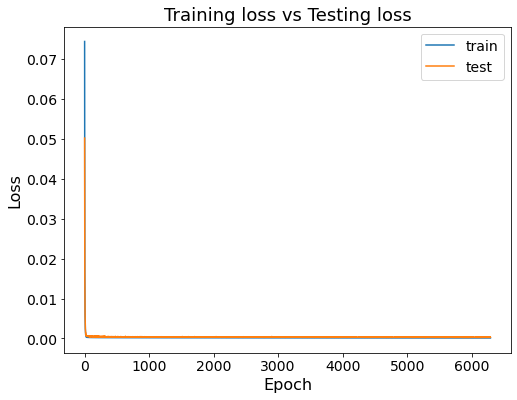

In [34]:
lr = 0.0001
EPOCHS = 8000

lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=5e-4, 
                                                          decay_steps=10000,
                                                          decay_rate=0.99)


ws_pararcnn.compile(
#               optimizer=Adam(learning_rate=lr, decay=lr/EPOCHS), 
              optimizer=Adam(learning_rate=lr_schedule),
#               optimizer='adam',
              loss='mse',
              metrics=['mae'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=1000)
mc = ModelCheckpoint('saved_model/ws_pararcnn_sc1_3layer_{}h.h5'.format(K), monitor='val_mae', mode='min', verbose=2, save_best_only=True)

history = ws_pararcnn.fit(train_X, train_y,
                    batch_size=512,
                    epochs=EPOCHS,
                    validation_data=(test_X, test_y),
                    verbose=2,
                    shuffle=True,
                       callbacks=[es, mc])

plt.rcParams["figure.figsize"] = (8, 6)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=14)
plt.title("Training loss vs Testing loss", fontsize=18)
# plt.savefig('graph/rnn_loss.png', dpi=300)
plt.show()

In [35]:
# model_load.predict(test_input).shape

### Performance

In [36]:
from tensorflow.keras.models import load_model

saved_model = load_model('saved_model/ws_pararcnn_sc1_3layer_{}h.h5'.format(K))

In [37]:
yhat = saved_model.predict(test_X)
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(test_y)

inv_yhat = pd.DataFrame(inv_yhat)
inv_y = pd.DataFrame(inv_y)
print("inv_y.shape, inv_yhat.shape", inv_y.shape, inv_yhat.shape)

inv_y.shape, inv_yhat.shape (19268, 96) (19268, 96)


In [38]:
# inv_y

In [39]:
# inv_yhat

In [40]:
print('MAE = {}'.format(float("{:.4f}".format(mae(inv_yhat.iloc[:, :], inv_y.iloc[:, :])))))
print('RMSE = {}'.format(float("{:.4f}".format(sqrt(mse(inv_yhat.iloc[:, :], inv_y.iloc[:, :]))))))

MAE = 0.0537
RMSE = 0.0759
